In [1]:
import sys
import os
import tarfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from scipy import ndimage, io, misc
from xml.dom import minidom
from matplotlib.pyplot import imshow

In [9]:
cd E:\dog-breed-classifier

E:\dog-breed-classifier


In [3]:
%matplotlib inline

In [14]:
def file_create(path):
    if  not os.path.exists(path):
        os.mkdir(path)
    

In [15]:
file_create('train')
file_create('test')
file_create('cropped')
file_create('cropped/train')
file_create('cropped/test')

In [3]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'
last_percent_reported = None
data_root = '.'
num_classes = 120
image_size = 224
num_channels = 3
np.random.seed(133)

In [17]:
def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 5% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

    last_percent_reported = percent

In [18]:
def maybe_download(filename, expected_bytes, force=False):
    """
    Download a file if not present, and make sure it's the right size.
    """
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

In [19]:
def maybe_extract(filename, check_classes=True, force=False):
    root = os.path.splitext(filename)[0]  # remove .tar
    if os.path.isdir(root) and not force:
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall(data_root)
        tar.close()
    if check_classes:
        data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]
        if len(data_folders) != num_classes:
            raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
        print('Completed extraction of %s.' % filename)
        return data_folders
    else:
        print('Completed extraction of %s.' % filename)

In [23]:
images_filename = maybe_download('images.tar', 793579520)
annotation_filename = maybe_download('annotation.tar', 21852160)
lists_filename = maybe_download('lists.tar', 481280)

Attempting to download: images.tar
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\images.tar
Attempting to download: annotation.tar
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\annotation.tar
Attempting to download: lists.tar
0%..5%..10%..15%..20%..25%..30%..35%..40%..45%...................80%..85%..90%..95%..100%
Download Complete!
Found and verified .\lists.tar


In [28]:
images_filename = 'images.tar'
annotation_filename = 'annotation.tar'

In [86]:
images_folders = maybe_extract(images_filename)
annotation_folders = maybe_extract(annotation_filename)
maybe_extract(lists_filename, check_classes=False)

Extracting data for images. This may take a while. Please wait.
Completed extraction of images.tar.
annotation already present - Skipping extraction of annotation.tar.
Completed extraction of annotation.tar.
Extracting data for .\lists. This may take a while. Please wait.
Completed extraction of .\lists.tar.


In [81]:
for folder in images_folders:
    os.makedirs("train/"+folder.split("\\")[-1])
    os.makedirs("test/"+folder.split("\\")[-1])
    os.makedirs("cropped/train/"+folder.split("\\")[-1])
    os.makedirs("cropped/test/"+folder.split("\\")[-1])

In [87]:
test_list = io.loadmat('test_list.mat')['file_list']
train_list = io.loadmat('train_list.mat')['file_list']

In [88]:
def move_data_files(image_list, new_folder):
    for file in image_list:
        if os.path.exists('Images/'+file[0][0]):
            shutil.move('Images/'+file[0][0],new_folder+'/'+file[0][0])
        elif not os.path.exists(new_folder+'/'+file[0][0]):
           print('%s does not exist, it may be missing' % os.path.exists('./images/'+file[0][0]))
    return [new_folder+'/'+d for d in sorted(os.listdir(new_folder)) if os.path.isdir(os.path.join(new_folder, d))]

In [89]:
test_folders = move_data_files(test_list, 'test')
train_folders = move_data_files(train_list, 'train')

In [4]:
def load_breed(folder):
    """
    Load the data for a single breed label.
    """
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = folder+'/'+image
        try:
            
            image_data = misc.imread(image_file)
            
            annon_file = 'Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]
            new_image_data = misc.imresize(new_image_data, (image_size, image_size))
            misc.imsave('cropped/' + folder + '/' + image, new_image_data)
            dataset[num_images, :, :, :] = new_image_data
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :, :]

    print('Full dataset tensor:', dataset.shape)
    return dataset

In [104]:
from keras.preprocessing import image
i=image.load_img('cropped/test/n02085620-Chihuahua/n02085620_588.jpg',target_size=(229,229))
image.img_to_array(i).shape

(229, 229, 3)

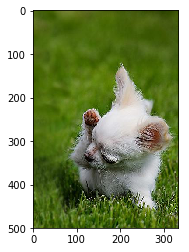

In [100]:
?misc.imread('test/n02085620-Chihuahua/n02085620_588.jpg')[:,:,:3]
imshow(a)

In [5]:
def maybe_pickle(data_folders, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_breed(folder)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

In [30]:
dataset = load_breed('train/n02105855-Shetland_sheepdog')
with open('n02105855-Shetland_sheepdog.pickle', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

train/n02105855-Shetland_sheepdog
Full dataset tensor: (100, 224, 224, 3)


In [6]:
train_folders=os.listdir('train')
train_folders=['train'+'/'+d for d in train_folders]
test_folders=os.listdir('test')
test_folders=['test'+'/'+d for d in test_folders]

In [8]:
train_datasets = maybe_pickle(train_folders, force=True)
test_datasets = maybe_pickle(test_folders, force=True)

Pickling train/n02085620-Chihuahua.pickle.
train/n02085620-Chihuahua
Could not read: train/n02085620-Chihuahua/n02085620_10621.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_10621' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_10976.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_10976' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_11140.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_11140' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_11238.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_11238' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_11258.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_11258' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_1152.jpg : [Errno 2] No 

Could not read: train/n02085620-Chihuahua/n02085620_3681.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_3681' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_3763.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_3763' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_382.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_382' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_3838.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_3838' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_3880.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_3880' - it's ok, skipping.
Could not read: train/n02085620-Chihuahua/n02085620_3928.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_3928' - it's ok

Could not read: train/n02085782-Japanese_spaniel/n02085782_1460.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_1460' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_1521.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_1521' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_1528.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_1528' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_1552.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_1552' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_1656.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_1656' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_1691.jpg : [Errno 2] No su

Could not read: train/n02085782-Japanese_spaniel/n02085782_3325.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_3325' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_3331.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_3331' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_3387.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_3387' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_3481.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_3481' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_3499.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_3499' - it's ok, skipping.
Could not read: train/n02085782-Japanese_spaniel/n02085782_3516.jpg : [Errno 2] No su

Could not read: train/n02085936-Maltese_dog/n02085936_1556.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_1556' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_16190.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_16190' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_16355.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_16355' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_16565.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_16565' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_17059.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_17059' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_17116.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Ma

Could not read: train/n02085936-Maltese_dog/n02085936_5582.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_5582' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_5596.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_5596' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_6405.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_6405' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_6424.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_6424' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_6464.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_6464' - it's ok, skipping.
Could not read: train/n02085936-Maltese_dog/n02085936_6514.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog

Could not read: train/n02086079-Pekinese/n02086079_15871.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_15871' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_15979.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_15979' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_16268.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_16268' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_16313.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_16313' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_16693.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_16693' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_17015.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_17015' - it's 

Could not read: train/n02086079-Pekinese/n02086079_7769.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_7769' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_7959.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_7959' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_8074.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_8074' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_8127.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_8127' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_8204.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_8204' - it's ok, skipping.
Could not read: train/n02086079-Pekinese/n02086079_8229.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_8229' - it's ok, skipping

Could not read: train/n02086240-Shih-Tzu/n02086240_3175.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3175' - it's ok, skipping.
Could not read: train/n02086240-Shih-Tzu/n02086240_323.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_323' - it's ok, skipping.
Could not read: train/n02086240-Shih-Tzu/n02086240_3254.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3254' - it's ok, skipping.
Could not read: train/n02086240-Shih-Tzu/n02086240_34.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_34' - it's ok, skipping.
Could not read: train/n02086240-Shih-Tzu/n02086240_3558.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3558' - it's ok, skipping.
Could not read: train/n02086240-Shih-Tzu/n02086240_3582.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3582' - it's ok, skipping.
Coul

Could not read: train/n02086240-Shih-Tzu/n02086240_963.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_963' - it's ok, skipping.
Could not read: train/n02086240-Shih-Tzu/n02086240_968.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_968' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02086646-Blenheim_spaniel.pickle.
train/n02086646-Blenheim_spaniel
Could not read: train/n02086646-Blenheim_spaniel/n02086646_1014.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_1014' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_1077.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_1077' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_1094.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_1094' - it's ok, skipping.


Could not read: train/n02086646-Blenheim_spaniel/n02086646_3052.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3052' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_3059.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3059' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_3161.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3161' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_3234.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3234' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_3256.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3256' - it's ok, skipping.
Could not read: train/n02086646-Blenheim_spaniel/n02086646_326.jpg : [Errno 2] No suc

Could not read: train/n02086910-papillon/n02086910_21.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_21' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_2168.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_2168' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_2235.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_2235' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_2335.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_2335' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_2359.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_2359' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_2410.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_2410' - it's ok, skipping.
Co

Could not read: train/n02086910-papillon/n02086910_6089.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_6089' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_6207.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_6207' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_6293.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_6293' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_6373.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_6373' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_6475.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_6475' - it's ok, skipping.
Could not read: train/n02086910-papillon/n02086910_6483.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_6483' - it's ok, skipping

Could not read: train/n02087046-toy_terrier/n02087046_336.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_336' - it's ok, skipping.
Could not read: train/n02087046-toy_terrier/n02087046_3439.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_3439' - it's ok, skipping.
Could not read: train/n02087046-toy_terrier/n02087046_3462.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_3462' - it's ok, skipping.
Could not read: train/n02087046-toy_terrier/n02087046_3471.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_3471' - it's ok, skipping.
Could not read: train/n02087046-toy_terrier/n02087046_3490.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_3490' - it's ok, skipping.
Could not read: train/n02087046-toy_terrier/n02087046_3560.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n

Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_10238.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_10238' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_10418.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_10418' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_10588.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_10588' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_10591.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_10591' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_10683.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_10683' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_rid

Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_4603.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_4603' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_4681.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_4681' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_4931.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_4931' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_5044.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_5044' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_514.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_514' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n0208

Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_9189.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_9189' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_9343.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_9343' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_9352.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_9352' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_9361.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_9361' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02087394_9520.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_9520' - it's ok, skipping.
Could not read: train/n02087394-Rhodesian_ridgeback/n02

Could not read: train/n02088094-Afghan_hound/n02088094_4072.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_4072' - it's ok, skipping.
Could not read: train/n02088094-Afghan_hound/n02088094_4219.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_4219' - it's ok, skipping.
Could not read: train/n02088094-Afghan_hound/n02088094_4314.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_4314' - it's ok, skipping.
Could not read: train/n02088094-Afghan_hound/n02088094_4352.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_4352' - it's ok, skipping.
Could not read: train/n02088094-Afghan_hound/n02088094_4396.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_4396' - it's ok, skipping.
Could not read: train/n02088094-Afghan_hound/n02088094_4406.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-

Could not read: train/n02088238-basset/n02088238_10129.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10129' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_10140.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10140' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_10142.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10142' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_10183.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10183' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_10245.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10245' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_10338.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10338' - it's ok, skipping.
Could not 

Could not read: train/n02088238-basset/n02088238_6532.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_6532' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_6621.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_6621' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_6708.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_6708' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_6988.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_6988' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_7131.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_7131' - it's ok, skipping.
Could not read: train/n02088238-basset/n02088238_7181.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_7181' - it's ok, skipping.
Could not read: train/

Could not read: train/n02088364-beagle/n02088364_12710.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_12710' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_12745.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_12745' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_12756.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_12756' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_12794.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_12794' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_12816.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_12816' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_12869.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_12869' - it's ok, skipping.
Could not 

Could not read: train/n02088364-beagle/n02088364_2415.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_2415' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_2499.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_2499' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_2661.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_2661' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_3752.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_3752' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_3758.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_3758' - it's ok, skipping.
Could not read: train/n02088364-beagle/n02088364_4052.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_4052' - it's ok, skipping.
Could not read: train/

Could not read: train/n02088466-bloodhound/n02088466_4907.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_4907' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_5212.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_5212' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_5521.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_5521' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_6096.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_6096' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_6126.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_6126' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_6413.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_6

Could not read: train/n02088466-bloodhound/n02088466_8772.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8772' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_8775.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8775' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_8807.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8807' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_8812.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8812' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_8813.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8813' - it's ok, skipping.
Could not read: train/n02088466-bloodhound/n02088466_8821.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8

Could not read: train/n02088632-bluetick/n02088632_2060.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_2060' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_2099.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_2099' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_2145.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_2145' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_2155.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_2155' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_2162.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_2162' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_2169.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_2169' - it's ok, skipping

Could not read: train/n02088632-bluetick/n02088632_4625.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_4625' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_4647.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_4647' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_4686.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_4686' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_512.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_512' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_600.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_600' - it's ok, skipping.
Could not read: train/n02088632-bluetick/n02088632_610.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_610' - it's ok, skipping.
Coul

Could not read: train/n02089078-black-and-tan_coonhound/n02089078_2404.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_2404' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_2417.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_2417' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_243.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_243' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_2478.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_2478' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_2498.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_2498' - it's ok, skipping.
Could not read: t

Could not read: train/n02089078-black-and-tan_coonhound/n02089078_52.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_52' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_641.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_641' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_663.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_663' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_695.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_695' - it's ok, skipping.
Could not read: train/n02089078-black-and-tan_coonhound/n02089078_779.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_779' - it's ok, skipping.
Could not read: train/n0208

Could not read: train/n02089867-Walker_hound/n02089867_2387.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2387' - it's ok, skipping.
Could not read: train/n02089867-Walker_hound/n02089867_2388.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2388' - it's ok, skipping.
Could not read: train/n02089867-Walker_hound/n02089867_24.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_24' - it's ok, skipping.
Could not read: train/n02089867-Walker_hound/n02089867_2432.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2432' - it's ok, skipping.
Could not read: train/n02089867-Walker_hound/n02089867_2472.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2472' - it's ok, skipping.
Could not read: train/n02089867-Walker_hound/n02089867_2479.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walk

Could not read: train/n02089973-English_foxhound/n02089973_1232.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_1232' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_1249.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_1249' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_1255.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_1255' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_1260.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_1260' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_1298.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_1298' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_1312.jpg : [Errno 2] No su

Could not read: train/n02089973-English_foxhound/n02089973_3454.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_3454' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_3604.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_3604' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_3647.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_3647' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_3651.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_3651' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_3671.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_3671' - it's ok, skipping.
Could not read: train/n02089973-English_foxhound/n02089973_3688.jpg : [Errno 2] No su

Could not read: train/n02090379-redbone/n02090379_1821.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_1821' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_1964.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_1964' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_2003.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_2003' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_2126.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_2126' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_2149.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_2149' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_2280.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_2280' - it's ok, skipping.
Could not 

Could not read: train/n02090379-redbone/n02090379_4875.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_4875' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_4918.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_4918' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_4950.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_4950' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_4973.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_4973' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_4987.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_4987' - it's ok, skipping.
Could not read: train/n02090379-redbone/n02090379_4997.jpg : [Errno 2] No such file or directory: 'Annotation/n02090379-redbone/n02090379_4997' - it's ok, skipping.
Could not 

Could not read: train/n02090622-borzoi/n02090622_6166.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_6166' - it's ok, skipping.
Could not read: train/n02090622-borzoi/n02090622_6293.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_6293' - it's ok, skipping.
Could not read: train/n02090622-borzoi/n02090622_6303.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_6303' - it's ok, skipping.
Could not read: train/n02090622-borzoi/n02090622_6372.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_6372' - it's ok, skipping.
Could not read: train/n02090622-borzoi/n02090622_6408.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_6408' - it's ok, skipping.
Could not read: train/n02090622-borzoi/n02090622_6443.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_6443' - it's ok, skipping.
Could not read: train/

Could not read: train/n02090622-borzoi/n02090622_9814.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_9814' - it's ok, skipping.
Could not read: train/n02090622-borzoi/n02090622_9883.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_9883' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02090721-Irish_wolfhound.pickle.
train/n02090721-Irish_wolfhound
Could not read: train/n02090721-Irish_wolfhound/n02090721_1002.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1002' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_1026.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1026' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_1085.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1085' - it's ok, skipping.
Could not re

Could not read: train/n02090721-Irish_wolfhound/n02090721_3763.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3763' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_3771.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3771' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_3773.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3773' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_3787.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3787' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_3900.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3900' - it's ok, skipping.
Could not read: train/n02090721-Irish_wolfhound/n02090721_4015.jpg : [Errno 2] No such file or 

Could not read: train/n02091032-Italian_greyhound/n02091032_10644.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_10644' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_10688.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_10688' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_10984.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_10984' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_1100.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_1100' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_11088.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_11088' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_1140.jp

Could not read: train/n02091032-Italian_greyhound/n02091032_490.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_490' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_4971.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_4971' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_5.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_5' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_5093.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_5093' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_5134.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_5134' - it's ok, skipping.
Could not read: train/n02091032-Italian_greyhound/n02091032_5383.jpg : [Errno 2] No

Could not read: train/n02091134-whippet/n02091134_12732.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_12732' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_12827.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_12827' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_13143.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_13143' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_13244.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_13244' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_13376.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_13376' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_13401.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_13401' - it's ok, skipping

Could not read: train/n02091134-whippet/n02091134_5630.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_5630' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_6616.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_6616' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_6699.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_6699' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_682.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_682' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_7232.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_7232' - it's ok, skipping.
Could not read: train/n02091134-whippet/n02091134_7375.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_7375' - it's ok, skipping.
Could not re

Could not read: train/n02091244-Ibizan_hound/n02091244_2464.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2464' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_2625.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2625' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_2695.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2695' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_2709.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2709' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_2742.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2742' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_2782.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-

Could not read: train/n02091244-Ibizan_hound/n02091244_5718.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_5718' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_5774.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_5774' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_5818.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_5818' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_589.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_589' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_5943.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_5943' - it's ok, skipping.
Could not read: train/n02091244-Ibizan_hound/n02091244_5982.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ib

Could not read: train/n02091467-Norwegian_elkhound/n02091467_3849.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_3849' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_3852.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_3852' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_3879.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_3879' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_3880.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_3880' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_410.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_410' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_4110.j

Could not read: train/n02091467-Norwegian_elkhound/n02091467_872.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_872' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_878.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_878' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_879.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_879' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_898.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_898' - it's ok, skipping.
Could not read: train/n02091467-Norwegian_elkhound/n02091467_92.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_92' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02091635-otterhound.pic

Could not read: train/n02091635-otterhound/n02091635_215.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_215' - it's ok, skipping.
Could not read: train/n02091635-otterhound/n02091635_2183.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2183' - it's ok, skipping.
Could not read: train/n02091635-otterhound/n02091635_2277.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2277' - it's ok, skipping.
Could not read: train/n02091635-otterhound/n02091635_2305.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2305' - it's ok, skipping.
Could not read: train/n02091635-otterhound/n02091635_239.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_239' - it's ok, skipping.
Could not read: train/n02091635-otterhound/n02091635_2464.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2464'

Could not read: train/n02091831-Saluki/n02091831_10978.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_10978' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_11021.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_11021' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_1118.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_1118' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_11224.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_11224' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_1182.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_1182' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_12653.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_12653' - it's ok, skipping.
Could not read

Could not read: train/n02091831-Saluki/n02091831_3899.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_3899' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_3909.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_3909' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_3962.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_3962' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_4030.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_4030' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_4087.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_4087' - it's ok, skipping.
Could not read: train/n02091831-Saluki/n02091831_4246.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_4246' - it's ok, skipping.
Could not read: train/

Could not read: train/n02092002-Scottish_deerhound/n02092002_1153.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_1153' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_1242.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_1242' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_12828.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_12828' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_12977.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_12977' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_13159.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_13159' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n0209200

Could not read: train/n02092002-Scottish_deerhound/n02092002_5226.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5226' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_5246.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5246' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_5664.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5664' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_5915.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5915' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_5960.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5960' - it's ok, skipping.
Could not read: train/n02092002-Scottish_deerhound/n02092002_6001

Could not read: train/n02092339-Weimaraner/n02092339_114.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_114' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_1509.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_1509' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_1521.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_1521' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_1700.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_1700' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_176.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_176' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_1796.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_1796'

Could not read: train/n02092339-Weimaraner/n02092339_6401.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_6401' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_6430.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_6430' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_6509.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_6509' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_6530.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_6530' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_6543.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_6543' - it's ok, skipping.
Could not read: train/n02092339-Weimaraner/n02092339_6620.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_6

Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_1546.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_1546' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_1549.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_1549' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_1602.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_1602' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_1638.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_1638' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_1745.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_1745' - it's ok, skipp

Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_567.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_567' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_5733.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_5733' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_5734.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_5734' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_5791.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_5791' - it's ok, skipping.
Could not read: train/n02093256-Staffordshire_bullterrier/n02093256_5820.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_5820' - it's ok, skippin

Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_14706.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_14706' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_1482.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_1482' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_14990.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_14990' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_15072.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_15072' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_15280.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-Americ

Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_4468.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_4468' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_4552.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_4552' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_4654.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_4654' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_5146.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staffordshire_terrier/n02093428_5146' - it's ok, skipping.
Could not read: train/n02093428-American_Staffordshire_terrier/n02093428_5165.jpg : [Errno 2] No such file or directory: 'Annotation/n02093428-American_Staf

Could not read: train/n02093647-Bedlington_terrier/n02093647_2335.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2335' - it's ok, skipping.
Could not read: train/n02093647-Bedlington_terrier/n02093647_2349.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2349' - it's ok, skipping.
Could not read: train/n02093647-Bedlington_terrier/n02093647_2354.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2354' - it's ok, skipping.
Could not read: train/n02093647-Bedlington_terrier/n02093647_2388.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2388' - it's ok, skipping.
Could not read: train/n02093647-Bedlington_terrier/n02093647_239.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_239' - it's ok, skipping.
Could not read: train/n02093647-Bedlington_terrier/n02093647_24.jpg

Could not read: train/n02093754-Border_terrier/n02093754_1247.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_1247' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_1256.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_1256' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_1310.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_1310' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_1422.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_1422' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_1464.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_1464' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_1536.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02093754-Border_terrier/n02093754_5975.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_5975' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_6089.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_6089' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_6098.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_6098' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_6248.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_6248' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_6257.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_6257' - it's ok, skipping.
Could not read: train/n02093754-Border_terrier/n02093754_6437.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02093859-Kerry_blue_terrier/n02093859_1453.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_1453' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_1498.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_1498' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_1571.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_1571' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_1598.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_1598' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_161.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_161' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_1628.j

Could not read: train/n02093859-Kerry_blue_terrier/n02093859_333.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_333' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_3376.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_3376' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_3382.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_3382' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_345.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_345' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_392.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_392' - it's ok, skipping.
Could not read: train/n02093859-Kerry_blue_terrier/n02093859_393.jpg : 

Could not read: train/n02093991-Irish_terrier/n02093991_2850.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_2850' - it's ok, skipping.
Could not read: train/n02093991-Irish_terrier/n02093991_287.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_287' - it's ok, skipping.
Could not read: train/n02093991-Irish_terrier/n02093991_2874.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_2874' - it's ok, skipping.
Could not read: train/n02093991-Irish_terrier/n02093991_2923.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_2923' - it's ok, skipping.
Could not read: train/n02093991-Irish_terrier/n02093991_2969.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_2969' - it's ok, skipping.
Could not read: train/n02093991-Irish_terrier/n02093991_2995.jpg : [Errno 2] No such file or directory: 'Annotation/n

Could not read: train/n02094114-Norfolk_terrier/n02094114_1610.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1610' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_1641.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1641' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_1665.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1665' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_1696.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1696' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_1734.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1734' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_1826.jpg : [Errno 2] No such file or 

Could not read: train/n02094114-Norfolk_terrier/n02094114_3686.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_3686' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_3733.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_3733' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_382.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_382' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_3826.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_3826' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_3890.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_3890' - it's ok, skipping.
Could not read: train/n02094114-Norfolk_terrier/n02094114_3925.jpg : [Errno 2] No such file or di

Could not read: train/n02094258-Norwich_terrier/n02094258_1460.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1460' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_1469.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1469' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_1510.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1510' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_1579.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1579' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_1614.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1614' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_1704.jpg : [Errno 2] No such file or 

Could not read: train/n02094258-Norwich_terrier/n02094258_3435.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_3435' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_3438.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_3438' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_3464.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_3464' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_3467.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_3467' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_3488.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_3488' - it's ok, skipping.
Could not read: train/n02094258-Norwich_terrier/n02094258_355.jpg : [Errno 2] No such file or d

Could not read: train/n02094433-Yorkshire_terrier/n02094433_2229.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_2229' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_225.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_225' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_2266.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_2266' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_2328.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_2328' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_2340.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_2340' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_2375.jpg : [Errno

Could not read: train/n02094433-Yorkshire_terrier/n02094433_6328.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_6328' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_6338.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_6338' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_6672.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_6672' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_668.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_668' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_730.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_730' - it's ok, skipping.
Could not read: train/n02094433-Yorkshire_terrier/n02094433_7394.jpg : [Errno 2

Could not read: train/n02095314-wire-haired_fox_terrier/n02095314_289.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_289' - it's ok, skipping.
Could not read: train/n02095314-wire-haired_fox_terrier/n02095314_2904.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2904' - it's ok, skipping.
Could not read: train/n02095314-wire-haired_fox_terrier/n02095314_2932.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2932' - it's ok, skipping.
Could not read: train/n02095314-wire-haired_fox_terrier/n02095314_2964.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2964' - it's ok, skipping.
Could not read: train/n02095314-wire-haired_fox_terrier/n02095314_3006.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_3006' - it's ok, skipping.
Could not read: t

Could not read: train/n02095570-Lakeland_terrier/n02095570_1663.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_1663' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_1752.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_1752' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_1765.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_1765' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_1816.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_1816' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_1867.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_1867' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_1947.jpg : [Errno 2] No su

Could not read: train/n02095570-Lakeland_terrier/n02095570_4650.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_4650' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_4656.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_4656' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_471.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_471' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_4762.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_4762' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_477.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_477' - it's ok, skipping.
Could not read: train/n02095570-Lakeland_terrier/n02095570_4782.jpg : [Errno 2] No such f

Could not read: train/n02095889-Sealyham_terrier/n02095889_41.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_41' - it's ok, skipping.
Could not read: train/n02095889-Sealyham_terrier/n02095889_4116.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_4116' - it's ok, skipping.
Could not read: train/n02095889-Sealyham_terrier/n02095889_4198.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_4198' - it's ok, skipping.
Could not read: train/n02095889-Sealyham_terrier/n02095889_4263.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_4263' - it's ok, skipping.
Could not read: train/n02095889-Sealyham_terrier/n02095889_4290.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_4290' - it's ok, skipping.
Could not read: train/n02095889-Sealyham_terrier/n02095889_4306.jpg : [Errno 2] No such f

Could not read: train/n02096051-Airedale/n02096051_183.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_183' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_1912.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_1912' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_2170.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_2170' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_225.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_225' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_2314.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_2314' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_2333.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_2333' - it's ok, skipping.
Co

Could not read: train/n02096051-Airedale/n02096051_738.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_738' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_7516.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_7516' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_7762.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_7762' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_7790.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_7790' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_7847.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_7847' - it's ok, skipping.
Could not read: train/n02096051-Airedale/n02096051_8019.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_8019' - it's ok, skipping.


Could not read: train/n02096177-cairn/n02096177_1946.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_1946' - it's ok, skipping.
Could not read: train/n02096177-cairn/n02096177_1988.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_1988' - it's ok, skipping.
Could not read: train/n02096177-cairn/n02096177_2020.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_2020' - it's ok, skipping.
Could not read: train/n02096177-cairn/n02096177_2061.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_2061' - it's ok, skipping.
Could not read: train/n02096177-cairn/n02096177_207.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_207' - it's ok, skipping.
Could not read: train/n02096177-cairn/n02096177_2143.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_2143' - it's ok, skipping.
Could not read: train/n02096177-cair

Could not read: train/n02096294-Australian_terrier/n02096294_1150.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_1150' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_1231.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_1231' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_1243.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_1243' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_1284.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_1284' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_1299.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_1299' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_1386

Could not read: train/n02096294-Australian_terrier/n02096294_3967.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_3967' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_4142.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_4142' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_4201.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_4201' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_4205.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_4205' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_4420.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_4420' - it's ok, skipping.
Could not read: train/n02096294-Australian_terrier/n02096294_4492

Could not read: train/n02096437-Dandie_Dinmont/n02096437_1054.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_1054' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_1070.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_1070' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_1135.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_1135' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_1143.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_1143' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_1171.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_1171' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_1219.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02096437-Dandie_Dinmont/n02096437_335.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_335' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_3356.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_3356' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_3427.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_3427' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_3431.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_3431' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_3451.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_3451' - it's ok, skipping.
Could not read: train/n02096437-Dandie_Dinmont/n02096437_3486.jpg : [Errno 2] No such file or directory: 'A

Could not read: train/n02096585-Boston_bull/n02096585_145.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_145' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_1532.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_1532' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_1559.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_1559' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_1562.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_1562' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_1568.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_1568' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_1571.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n

Could not read: train/n02096585-Boston_bull/n02096585_942.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_942' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_9534.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_9534' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_9681.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_9681' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_9834.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_9834' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_9909.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_9909' - it's ok, skipping.
Could not read: train/n02096585-Boston_bull/n02096585_9912.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n

Could not read: train/n02097047-miniature_schnauzer/n02097047_328.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_328' - it's ok, skipping.
Could not read: train/n02097047-miniature_schnauzer/n02097047_3429.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_3429' - it's ok, skipping.
Could not read: train/n02097047-miniature_schnauzer/n02097047_3579.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_3579' - it's ok, skipping.
Could not read: train/n02097047-miniature_schnauzer/n02097047_37.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_37' - it's ok, skipping.
Could not read: train/n02097047-miniature_schnauzer/n02097047_3978.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_3978' - it's ok, skipping.
Could not read: train/n02097047-miniature_schnauzer/n02097047

Could not read: train/n02097130-giant_schnauzer/n02097130_1862.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_1862' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_1894.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_1894' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_1978.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_1978' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_1991.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_1991' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_2135.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_2135' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_2149.jpg : [Errno 2] No such file or 

Could not read: train/n02097130-giant_schnauzer/n02097130_5576.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5576' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_5618.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5618' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_5675.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5675' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_5708.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5708' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_5750.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5750' - it's ok, skipping.
Could not read: train/n02097130-giant_schnauzer/n02097130_5765.jpg : [Errno 2] No such file or 

Could not read: train/n02097209-standard_schnauzer/n02097209_2347.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_2347' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_2365.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_2365' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_2423.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_2423' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_2432.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_2432' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_2468.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_2468' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_2505

Could not read: train/n02097209-standard_schnauzer/n02097209_469.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_469' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_4712.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_4712' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_49.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_49' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_5027.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_5027' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_541.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_541' - it's ok, skipping.
Could not read: train/n02097209-standard_schnauzer/n02097209_548.jpg : [E

Could not read: train/n02097298-Scotch_terrier/n02097298_3618.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_3618' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_3641.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_3641' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_3780.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_3780' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_39.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_39' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_4092.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_4092' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_4162.jpg : [Errno 2] No such file or directory: 'Ann

Could not read: train/n02097298-Scotch_terrier/n02097298_8858.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_8858' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_8918.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_8918' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_92.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_92' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_9217.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_9217' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_9251.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_9251' - it's ok, skipping.
Could not read: train/n02097298-Scotch_terrier/n02097298_9293.jpg : [Errno 2] No such file or directory: 'Ann

Could not read: train/n02097474-Tibetan_terrier/n02097474_4053.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_4053' - it's ok, skipping.
Could not read: train/n02097474-Tibetan_terrier/n02097474_4404.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_4404' - it's ok, skipping.
Could not read: train/n02097474-Tibetan_terrier/n02097474_4589.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_4589' - it's ok, skipping.
Could not read: train/n02097474-Tibetan_terrier/n02097474_4713.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_4713' - it's ok, skipping.
Could not read: train/n02097474-Tibetan_terrier/n02097474_477.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_477' - it's ok, skipping.
Could not read: train/n02097474-Tibetan_terrier/n02097474_4772.jpg : [Errno 2] No such file or di

Could not read: train/n02097658-silky_terrier/n02097658_1086.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1086' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_1098.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1098' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_1106.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1106' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_11235.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_11235' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_11242.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_11242' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_11363.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: train/n02097658-silky_terrier/n02097658_6044.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_6044' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_611.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_611' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_6202.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_6202' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_6289.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_6289' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_633.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_633' - it's ok, skipping.
Could not read: train/n02097658-silky_terrier/n02097658_6357.jpg : [Errno 2] No such file or directory: 'Annotation/n02

Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_1743.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_1743' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_1777.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_1777' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_1789.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_1789' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_1791.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_1791' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_1837.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_18

Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_408.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_408' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_4105.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_4105' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_4120.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_4120' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_4164.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_4164' - it's ok, skipping.
Could not read: train/n02098105-soft-coated_wheaten_terrier/n02098105_4174.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_4174

Could not read: train/n02098286-West_Highland_white_terrier/n02098286_3258.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_3258' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_3263.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_3263' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_3290.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_3290' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_3329.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_3329' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_3432.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_34

Could not read: train/n02098286-West_Highland_white_terrier/n02098286_5829.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5829' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_5902.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5902' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_5979.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5979' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_6041.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_6041' - it's ok, skipping.
Could not read: train/n02098286-West_Highland_white_terrier/n02098286_6148.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_61

Could not read: train/n02098413-Lhasa/n02098413_18548.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_18548' - it's ok, skipping.
Could not read: train/n02098413-Lhasa/n02098413_18647.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_18647' - it's ok, skipping.
Could not read: train/n02098413-Lhasa/n02098413_18706.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_18706' - it's ok, skipping.
Could not read: train/n02098413-Lhasa/n02098413_19649.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_19649' - it's ok, skipping.
Could not read: train/n02098413-Lhasa/n02098413_20034.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_20034' - it's ok, skipping.
Could not read: train/n02098413-Lhasa/n02098413_20304.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_20304' - it's ok, skipping.
Could not read: train/

Could not read: train/n02098413-Lhasa/n02098413_932.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_932' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02099267-flat-coated_retriever.pickle.
train/n02099267-flat-coated_retriever
Could not read: train/n02099267-flat-coated_retriever/n02099267_1069.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_1069' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_1118.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_1118' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_1205.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_1205' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_1272.jpg : [Errno 2] No such file or directory: 'Annotation/n020992

Could not read: train/n02099267-flat-coated_retriever/n02099267_3768.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_3768' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_3787.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_3787' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_3843.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_3843' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_3864.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_3864' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_3868.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_3868' - it's ok, skipping.
Could not read: train/n02099267-fla

Could not read: train/n02099267-flat-coated_retriever/n02099267_979.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_979' - it's ok, skipping.
Could not read: train/n02099267-flat-coated_retriever/n02099267_997.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_997' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02099429-curly-coated_retriever.pickle.
train/n02099429-curly-coated_retriever
Could not read: train/n02099429-curly-coated_retriever/n02099429_1122.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_1122' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_1165.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_1165' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_1178.jpg : [Errno 2] No such f

Could not read: train/n02099429-curly-coated_retriever/n02099429_2767.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_2767' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_2776.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_2776' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_282.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_282' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_2838.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_2838' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_2839.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_2839' - it's ok, skipping.
Could not read: train/n0209

Could not read: train/n02099429-curly-coated_retriever/n02099429_915.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_915' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_935.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_935' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_946.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_946' - it's ok, skipping.
Could not read: train/n02099429-curly-coated_retriever/n02099429_961.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_961' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02099601-golden_retriever.pickle.
train/n02099601-golden_retriever
Could not read: train/n02099601-golden_retriever/n02099601_10.jpg : [Errno 2] No such file or directory: 'A

Could not read: train/n02099601-golden_retriever/n02099601_5857.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_5857' - it's ok, skipping.
Could not read: train/n02099601-golden_retriever/n02099601_6099.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_6099' - it's ok, skipping.
Could not read: train/n02099601-golden_retriever/n02099601_6105.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_6105' - it's ok, skipping.
Could not read: train/n02099601-golden_retriever/n02099601_6139.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_6139' - it's ok, skipping.
Could not read: train/n02099601-golden_retriever/n02099601_6194.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_6194' - it's ok, skipping.
Could not read: train/n02099601-golden_retriever/n02099601_6331.jpg : [Errno 2] No su

Could not read: train/n02099712-Labrador_retriever/n02099712_3500.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_3500' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_3503.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_3503' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_357.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_357' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_3613.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_3613' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_3698.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_3698' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_3773.j

Could not read: train/n02099712-Labrador_retriever/n02099712_7411.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_7411' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_7418.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_7418' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_7481.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_7481' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_7533.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_7533' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_7608.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_7608' - it's ok, skipping.
Could not read: train/n02099712-Labrador_retriever/n02099712_7664

Could not read: train/n02099849-Chesapeake_Bay_retriever/n02099849_3736.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3736' - it's ok, skipping.
Could not read: train/n02099849-Chesapeake_Bay_retriever/n02099849_3753.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3753' - it's ok, skipping.
Could not read: train/n02099849-Chesapeake_Bay_retriever/n02099849_3777.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3777' - it's ok, skipping.
Could not read: train/n02099849-Chesapeake_Bay_retriever/n02099849_3789.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3789' - it's ok, skipping.
Could not read: train/n02099849-Chesapeake_Bay_retriever/n02099849_3810.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3810' - it's ok, skipping.
Could

Could not read: train/n02100236-German_short-haired_pointer/n02100236_1529.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_1529' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_1553.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_1553' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_156.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_156' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_1673.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_1673' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_1687.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_1687

Could not read: train/n02100236-German_short-haired_pointer/n02100236_4463.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_4463' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_4465.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_4465' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_4508.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_4508' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_4556.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_4556' - it's ok, skipping.
Could not read: train/n02100236-German_short-haired_pointer/n02100236_4657.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_46

Could not read: train/n02100583-vizsla/n02100583_11665.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_11665' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_11701.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_11701' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_11710.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_11710' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_11752.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_11752' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_11888.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_11888' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_12047.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_12047' - it's ok, skipping.
Could not 

Could not read: train/n02100583-vizsla/n02100583_9844.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_9844' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_9884.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_9884' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_9902.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_9902' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_9956.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_9956' - it's ok, skipping.
Could not read: train/n02100583-vizsla/n02100583_9969.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_9969' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02100735-English_setter.pickle.
train/n02100735-English_setter
Could not read: train/n02100735-English_setter/n02100735_10030.jpg :

Could not read: train/n02100735-English_setter/n02100735_4949.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_4949' - it's ok, skipping.
Could not read: train/n02100735-English_setter/n02100735_4972.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_4972' - it's ok, skipping.
Could not read: train/n02100735-English_setter/n02100735_5054.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_5054' - it's ok, skipping.
Could not read: train/n02100735-English_setter/n02100735_523.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_523' - it's ok, skipping.
Could not read: train/n02100735-English_setter/n02100735_5234.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_5234' - it's ok, skipping.
Could not read: train/n02100735-English_setter/n02100735_5258.jpg : [Errno 2] No such file or directory: 'A

Could not read: train/n02100877-Irish_setter/n02100877_156.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_156' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_1669.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_1669' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_1749.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_1749' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_1776.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_1776' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_1787.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_1787' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_18.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Iris

Could not read: train/n02100877-Irish_setter/n02100877_5986.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_5986' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_5998.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_5998' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_6030.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_6030' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_6214.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_6214' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_6417.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_6417' - it's ok, skipping.
Could not read: train/n02100877-Irish_setter/n02100877_6436.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-

Could not read: train/n02101006-Gordon_setter/n02101006_2113.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_2113' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_22.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_22' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_2232.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_2232' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_228.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_228' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_2316.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_2316' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_2397.jpg : [Errno 2] No such file or directory: 'Annotation/n0210

Could not read: train/n02101006-Gordon_setter/n02101006_709.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_709' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_714.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_714' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_751.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_751' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_761.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_761' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_7867.jpg : [Errno 2] No such file or directory: 'Annotation/n02101006-Gordon_setter/n02101006_7867' - it's ok, skipping.
Could not read: train/n02101006-Gordon_setter/n02101006_795.jpg : [Errno 2] No such file or directory: 'Annotation/n0210100

Could not read: train/n02101388-Brittany_spaniel/n02101388_4422.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4422' - it's ok, skipping.
Could not read: train/n02101388-Brittany_spaniel/n02101388_4556.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4556' - it's ok, skipping.
Could not read: train/n02101388-Brittany_spaniel/n02101388_4628.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4628' - it's ok, skipping.
Could not read: train/n02101388-Brittany_spaniel/n02101388_4737.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4737' - it's ok, skipping.
Could not read: train/n02101388-Brittany_spaniel/n02101388_4762.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4762' - it's ok, skipping.
Could not read: train/n02101388-Brittany_spaniel/n02101388_4808.jpg : [Errno 2] No su

Could not read: train/n02101556-clumber/n02101556_2918.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_2918' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_2928.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_2928' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_3100.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_3100' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_3122.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_3122' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_3140.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_3140' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_3204.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_3204' - it's ok, skipping.
Could not 

Could not read: train/n02101556-clumber/n02101556_6228.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_6228' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_6433.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_6433' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_651.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_651' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_6573.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_6573' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_6603.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_6603' - it's ok, skipping.
Could not read: train/n02101556-clumber/n02101556_6842.jpg : [Errno 2] No such file or directory: 'Annotation/n02101556-clumber/n02101556_6842' - it's ok, skipping.
Could not re

Could not read: train/n02102040-English_springer/n02102040_2959.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_2959' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_3006.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_3006' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_3096.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_3096' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_312.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_312' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_3207.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_3207' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_3225.jpg : [Errno 2] No such

Could not read: train/n02102040-English_springer/n02102040_682.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_682' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_6843.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_6843' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_6846.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_6846' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_688.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_688' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_6890.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_6890' - it's ok, skipping.
Could not read: train/n02102040-English_springer/n02102040_690.jpg : [Errno 2] No such fi

Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_2611.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2611' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_2621.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2621' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_2628.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2628' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_2755.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2755' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_2852.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2852' - it's ok, skipping.
Could not read: train/n02

Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_528.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_528' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_656.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_656' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_66.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_66' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_661.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_661' - it's ok, skipping.
Could not read: train/n02102177-Welsh_springer_spaniel/n02102177_67.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_67' - it's ok, skipping.
Could not read: train/n02102177-Welsh_s

Could not read: train/n02102318-cocker_spaniel/n02102318_12887.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_12887' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_13800.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_13800' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_14073.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_14073' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_14111.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_14111' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_14555.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_14555' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_1458.jpg : [Errno 2] No such file or d

Could not read: train/n02102318-cocker_spaniel/n02102318_8504.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_8504' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_8518.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_8518' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_8534.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_8534' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_8666.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_8666' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_8697.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_8697' - it's ok, skipping.
Could not read: train/n02102318-cocker_spaniel/n02102318_873.jpg : [Errno 2] No such file or directory: '

Could not read: train/n02102480-Sussex_spaniel/n02102480_424.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_424' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_4244.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_4244' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_4270.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_4270' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_4295.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_4295' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_4365.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_4365' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_4373.jpg : [Errno 2] No such file or directory: 'A

Could not read: train/n02102480-Sussex_spaniel/n02102480_6620.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_6620' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_6651.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_6651' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_6780.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_6780' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_6842.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_6842' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_6922.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_6922' - it's ok, skipping.
Could not read: train/n02102480-Sussex_spaniel/n02102480_6995.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02102973-Irish_water_spaniel/n02102973_2569.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_2569' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_2595.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_2595' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_26.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_26' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_2642.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_2642' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_2645.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_2645' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n021029

Could not read: train/n02102973-Irish_water_spaniel/n02102973_634.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_634' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_644.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_644' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_720.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_720' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_721.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_721' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_723.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_723' - it's ok, skipping.
Could not read: train/n02102973-Irish_water_spaniel/n02102973_746

Could not read: train/n02104029-kuvasz/n02104029_2769.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_2769' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_2861.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_2861' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_2931.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_2931' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_2992.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_2992' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_3217.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_3217' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_3353.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_3353' - it's ok, skipping.
Could not read: train/

Could not read: train/n02104029-kuvasz/n02104029_690.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_690' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_792.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_792' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_897.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_897' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_898.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_898' - it's ok, skipping.
Could not read: train/n02104029-kuvasz/n02104029_951.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_951' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02104365-schipperke.pickle.
train/n02104365-schipperke
Could not read: train/n02104365-schipperke/n02104365_10139.jpg : [Errno 2] No such fil

Could not read: train/n02104365-schipperke/n02104365_7381.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_7381' - it's ok, skipping.
Could not read: train/n02104365-schipperke/n02104365_7409.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_7409' - it's ok, skipping.
Could not read: train/n02104365-schipperke/n02104365_7501.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_7501' - it's ok, skipping.
Could not read: train/n02104365-schipperke/n02104365_7518.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_7518' - it's ok, skipping.
Could not read: train/n02104365-schipperke/n02104365_7546.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_7546' - it's ok, skipping.
Could not read: train/n02104365-schipperke/n02104365_7629.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_7

Could not read: train/n02105056-groenendael/n02105056_2200.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_2200' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_2556.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_2556' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_2639.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_2639' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_2649.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_2649' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_2678.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_2678' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_2685.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael

Could not read: train/n02105056-groenendael/n02105056_6024.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_6024' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_6038.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_6038' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_6127.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_6127' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_6363.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_6363' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_6474.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_6474' - it's ok, skipping.
Could not read: train/n02105056-groenendael/n02105056_6534.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael

Could not read: train/n02105162-malinois/n02105162_5385.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_5385' - it's ok, skipping.
Could not read: train/n02105162-malinois/n02105162_5417.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_5417' - it's ok, skipping.
Could not read: train/n02105162-malinois/n02105162_5462.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_5462' - it's ok, skipping.
Could not read: train/n02105162-malinois/n02105162_5470.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_5470' - it's ok, skipping.
Could not read: train/n02105162-malinois/n02105162_5519.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_5519' - it's ok, skipping.
Could not read: train/n02105162-malinois/n02105162_5547.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_5547' - it's ok, skipping

Could not read: train/n02105251-briard/n02105251_5303.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_5303' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_5304.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_5304' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_5309.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_5309' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_5337.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_5337' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_5384.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_5384' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_5556.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_5556' - it's ok, skipping.
Could not read: train/

Could not read: train/n02105251-briard/n02105251_8384.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8384' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_8540.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8540' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_8543.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8543' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_8552.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8552' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_8560.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8560' - it's ok, skipping.
Could not read: train/n02105251-briard/n02105251_8587.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8587' - it's ok, skipping.
Could not read: train/

Could not read: train/n02105412-kelpie/n02105412_3693.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_3693' - it's ok, skipping.
Could not read: train/n02105412-kelpie/n02105412_3779.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_3779' - it's ok, skipping.
Could not read: train/n02105412-kelpie/n02105412_3786.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_3786' - it's ok, skipping.
Could not read: train/n02105412-kelpie/n02105412_3905.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_3905' - it's ok, skipping.
Could not read: train/n02105412-kelpie/n02105412_3979.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_3979' - it's ok, skipping.
Could not read: train/n02105412-kelpie/n02105412_4061.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_4061' - it's ok, skipping.
Could not read: train/

Could not read: train/n02105505-komondor/n02105505_1383.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_1383' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_1406.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_1406' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_1443.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_1443' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_1541.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_1541' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_1657.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_1657' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_192.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_192' - it's ok, skipping.


Could not read: train/n02105505-komondor/n02105505_4282.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_4282' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_4290.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_4290' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_4302.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_4302' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_4311.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_4311' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_4325.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_4325' - it's ok, skipping.
Could not read: train/n02105505-komondor/n02105505_4329.jpg : [Errno 2] No such file or directory: 'Annotation/n02105505-komondor/n02105505_4329' - it's ok, skipping

Could not read: train/n02105641-Old_English_sheepdog/n02105641_4268.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_4268' - it's ok, skipping.
Could not read: train/n02105641-Old_English_sheepdog/n02105641_4443.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_4443' - it's ok, skipping.
Could not read: train/n02105641-Old_English_sheepdog/n02105641_4577.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_4577' - it's ok, skipping.
Could not read: train/n02105641-Old_English_sheepdog/n02105641_4594.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_4594' - it's ok, skipping.
Could not read: train/n02105641-Old_English_sheepdog/n02105641_4751.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_4751' - it's ok, skipping.
Could not read: train/n02105641-Old_English_s

Pickling train/n02105855-Shetland_sheepdog.pickle.
train/n02105855-Shetland_sheepdog
Could not read: train/n02105855-Shetland_sheepdog/n02105855_1013.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_1013' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_10608.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10608' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_10619.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10619' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_10636.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10636' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_10729.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10729' - i

Could not read: train/n02105855-Shetland_sheepdog/n02105855_19782.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_19782' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_19944.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_19944' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_2039.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_2039' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_2172.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_2172' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_2376.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_2376' - it's ok, skipping.
Could not read: train/n02105855-Shetland_sheepdog/n02105855_2853.jpg : 

Could not read: train/n02106030-collie/n02106030_15008.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_15008' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_15054.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_15054' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_15172.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_15172' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_15284.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_15284' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_15388.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_15388' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_15577.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_15577' - it's ok, skipping.
Could not 

Could not read: train/n02106030-collie/n02106030_2548.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_2548' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_2844.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_2844' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_356.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_356' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_3776.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_3776' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_3948.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_3948' - it's ok, skipping.
Could not read: train/n02106030-collie/n02106030_4592.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_4592' - it's ok, skipping.
Could not read: train/n0

Could not read: train/n02106166-Border_collie/n02106166_1874.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_1874' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_1936.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_1936' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_1983.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_1983' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_2043.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_2043' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_2345.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_2345' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_243.jpg : [Errno 2] No such file or directory: 'Annotation/

Could not read: train/n02106166-Border_collie/n02106166_6698.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_6698' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_678.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_678' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_6824.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_6824' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_6833.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_6833' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_6879.jpg : [Errno 2] No such file or directory: 'Annotation/n02106166-Border_collie/n02106166_6879' - it's ok, skipping.
Could not read: train/n02106166-Border_collie/n02106166_7.jpg : [Errno 2] No such file or directory: 'Annotation/n021

Could not read: train/n02106382-Bouvier_des_Flandres/n02106382_2529.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2529' - it's ok, skipping.
Could not read: train/n02106382-Bouvier_des_Flandres/n02106382_2533.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2533' - it's ok, skipping.
Could not read: train/n02106382-Bouvier_des_Flandres/n02106382_2535.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2535' - it's ok, skipping.
Could not read: train/n02106382-Bouvier_des_Flandres/n02106382_2543.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2543' - it's ok, skipping.
Could not read: train/n02106382-Bouvier_des_Flandres/n02106382_2553.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2553' - it's ok, skipping.
Could not read: train/n02106382-Bouvier_des_F

Could not read: train/n02106550-Rottweiler/n02106550_11244.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_11244' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_11323.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_11323' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_11354.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_11354' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_11433.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_11433' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_11444.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_11444' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_11465.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/

Could not read: train/n02106550-Rottweiler/n02106550_8437.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_8437' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_8611.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_8611' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_8652.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_8652' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_8776.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_8776' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_895.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_895' - it's ok, skipping.
Could not read: train/n02106550-Rottweiler/n02106550_9084.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_908

Could not read: train/n02106662-German_shepherd/n02106662_2740.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_2740' - it's ok, skipping.
Could not read: train/n02106662-German_shepherd/n02106662_2810.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_2810' - it's ok, skipping.
Could not read: train/n02106662-German_shepherd/n02106662_320.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_320' - it's ok, skipping.
Could not read: train/n02106662-German_shepherd/n02106662_3260.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_3260' - it's ok, skipping.
Could not read: train/n02106662-German_shepherd/n02106662_3781.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_3781' - it's ok, skipping.
Could not read: train/n02106662-German_shepherd/n02106662_3815.jpg : [Errno 2] No such file or di

Could not read: train/n02107142-Doberman/n02107142_1694.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_1694' - it's ok, skipping.
Could not read: train/n02107142-Doberman/n02107142_17111.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_17111' - it's ok, skipping.
Could not read: train/n02107142-Doberman/n02107142_17147.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_17147' - it's ok, skipping.
Could not read: train/n02107142-Doberman/n02107142_17564.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_17564' - it's ok, skipping.
Could not read: train/n02107142-Doberman/n02107142_17788.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_17788' - it's ok, skipping.
Could not read: train/n02107142-Doberman/n02107142_17899.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_17899' - it's ok

Could not read: train/n02107312-miniature_pinscher/n02107312_1885.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_1885' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_1971.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_1971' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_2203.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_2203' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_2295.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_2295' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_2453.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_2453' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_2468

Could not read: train/n02107312-miniature_pinscher/n02107312_5287.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5287' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_5290.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5290' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_5299.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5299' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_5357.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5357' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_5385.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5385' - it's ok, skipping.
Could not read: train/n02107312-miniature_pinscher/n02107312_5407

Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1097.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1097' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1118.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1118' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1132.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1132' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1180.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1180' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_1246.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1246' - it's

Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3236.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_3236' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3270.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_3270' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_3274.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_3274' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_330.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_330' - it's ok, skipping.
Could not read: train/n02107574-Greater_Swiss_Mountain_dog/n02107574_344.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_344' - it's ok,

Could not read: train/n02107683-Bernese_mountain_dog/n02107683_275.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_275' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_2758.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_2758' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_2771.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_2771' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_2946.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_2946' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_3034.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_3034' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountai

Could not read: train/n02107683-Bernese_mountain_dog/n02107683_6660.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_6660' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_673.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_673' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_6752.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_6752' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_6772.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_6772' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountain_dog/n02107683_6800.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_6800' - it's ok, skipping.
Could not read: train/n02107683-Bernese_mountai

Could not read: train/n02107908-Appenzeller/n02107908_4092.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_4092' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_4142.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_4142' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_4247.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_4247' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_4296.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_4296' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_4301.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_4301' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_4669.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller

Could not read: train/n02107908-Appenzeller/n02107908_8207.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_8207' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_849.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_849' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_895.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_895' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_9.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_9' - it's ok, skipping.
Could not read: train/n02107908-Appenzeller/n02107908_94.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_94' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02108000-EntleBucher.pickle.
train/n02108000-EntleBucher
Could not read: train/n02108000-EntleB

Could not read: train/n02108000-EntleBucher/n02108000_3104.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_3104' - it's ok, skipping.
Could not read: train/n02108000-EntleBucher/n02108000_3138.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_3138' - it's ok, skipping.
Could not read: train/n02108000-EntleBucher/n02108000_316.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_316' - it's ok, skipping.
Could not read: train/n02108000-EntleBucher/n02108000_3171.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_3171' - it's ok, skipping.
Could not read: train/n02108000-EntleBucher/n02108000_3207.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_3207' - it's ok, skipping.
Could not read: train/n02108000-EntleBucher/n02108000_324.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n0

Could not read: train/n02108089-boxer/n02108089_1748.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1748' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_1757.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1757' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_1775.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1775' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_1859.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1859' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_1912.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1912' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_1956.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1956' - it's ok, skipping.
Could not read: train/n02108089-bo

Could not read: train/n02108089-boxer/n02108089_813.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_813' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_836.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_836' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_8969.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_8969' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_9045.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_9045' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_922.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_922' - it's ok, skipping.
Could not read: train/n02108089-boxer/n02108089_926.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_926' - it's ok, skipping.
Could not read: train/n02108089-boxer/n021

Could not read: train/n02108422-bull_mastiff/n02108422_3618.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_3618' - it's ok, skipping.
Could not read: train/n02108422-bull_mastiff/n02108422_3641.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_3641' - it's ok, skipping.
Could not read: train/n02108422-bull_mastiff/n02108422_3647.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_3647' - it's ok, skipping.
Could not read: train/n02108422-bull_mastiff/n02108422_3708.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_3708' - it's ok, skipping.
Could not read: train/n02108422-bull_mastiff/n02108422_3709.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_3709' - it's ok, skipping.
Could not read: train/n02108422-bull_mastiff/n02108422_3711.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-

Could not read: train/n02108551-Tibetan_mastiff/n02108551_1104.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_1104' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_1155.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_1155' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_11671.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_11671' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_1240.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_1240' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_12438.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_12438' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_1287.jpg : [Errno 2] No such file

Could not read: train/n02108551-Tibetan_mastiff/n02108551_5540.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_5540' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_5625.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_5625' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_598.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_598' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_6100.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_6100' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_6295.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_6295' - it's ok, skipping.
Could not read: train/n02108551-Tibetan_mastiff/n02108551_634.jpg : [Errno 2] No such file or dir

Could not read: train/n02108915-French_bulldog/n02108915_2545.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_2545' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_2570.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_2570' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_2681.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_2681' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_2835.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_2835' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_2899.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_2899' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_2946.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02108915-French_bulldog/n02108915_644.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_644' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_6462.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_6462' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_6521.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_6521' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_759.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_759' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_7608.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_7608' - it's ok, skipping.
Could not read: train/n02108915-French_bulldog/n02108915_7883.jpg : [Errno 2] No such file or directory: 'Ann

Could not read: train/n02109047-Great_Dane/n02109047_27409.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_27409' - it's ok, skipping.
Could not read: train/n02109047-Great_Dane/n02109047_27476.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_27476' - it's ok, skipping.
Could not read: train/n02109047-Great_Dane/n02109047_28208.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_28208' - it's ok, skipping.
Could not read: train/n02109047-Great_Dane/n02109047_28433.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_28433' - it's ok, skipping.
Could not read: train/n02109047-Great_Dane/n02109047_2851.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_2851' - it's ok, skipping.
Could not read: train/n02109047-Great_Dane/n02109047_2859.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02

Could not read: train/n02109525-Saint_Bernard/n02109525_12610.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_12610' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_1271.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_1271' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_1314.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_1314' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_13154.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_13154' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_13410.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_13410' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_13655.jpg : [Errno 2] No such file or directory: 'Ann

Could not read: train/n02109525-Saint_Bernard/n02109525_823.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_823' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_8312.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_8312' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_8417.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_8417' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_8822.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_8822' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_9130.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_9130' - it's ok, skipping.
Could not read: train/n02109525-Saint_Bernard/n02109525_9426.jpg : [Errno 2] No such file or directory: 'Annotation/n

Could not read: train/n02109961-Eskimo_dog/n02109961_3902.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_3902' - it's ok, skipping.
Could not read: train/n02109961-Eskimo_dog/n02109961_391.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_391' - it's ok, skipping.
Could not read: train/n02109961-Eskimo_dog/n02109961_3946.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_3946' - it's ok, skipping.
Could not read: train/n02109961-Eskimo_dog/n02109961_3984.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_3984' - it's ok, skipping.
Could not read: train/n02109961-Eskimo_dog/n02109961_3992.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_3992' - it's ok, skipping.
Could not read: train/n02109961-Eskimo_dog/n02109961_4054.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_405

Could not read: train/n02110063-malamute/n02110063_12139.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_12139' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_12269.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_12269' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_12294.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_12294' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_12326.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_12326' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_12330.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_12330' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_12449.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_12449' - it's 

Could not read: train/n02110063-malamute/n02110063_899.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_899' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_9112.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_9112' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_9259.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_9259' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_938.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_938' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_97.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_97' - it's ok, skipping.
Could not read: train/n02110063-malamute/n02110063_9861.jpg : [Errno 2] No such file or directory: 'Annotation/n02110063-malamute/n02110063_9861' - it's ok, skipping.
Full d

Could not read: train/n02110185-Siberian_husky/n02110185_4030.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_4030' - it's ok, skipping.
Could not read: train/n02110185-Siberian_husky/n02110185_4060.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_4060' - it's ok, skipping.
Could not read: train/n02110185-Siberian_husky/n02110185_4115.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_4115' - it's ok, skipping.
Could not read: train/n02110185-Siberian_husky/n02110185_4133.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_4133' - it's ok, skipping.
Could not read: train/n02110185-Siberian_husky/n02110185_4294.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_4294' - it's ok, skipping.
Could not read: train/n02110185-Siberian_husky/n02110185_4522.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02110627-affenpinscher/n02110627_10225.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_10225' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_10437.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_10437' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_10439.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_10439' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_10447.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_10447' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_10848.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_10848' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_10859.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02110627-affenpinscher/n02110627_2997.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_2997' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_3001.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_3001' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_3026.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_3026' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_3032.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_3032' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_3246.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_3246' - it's ok, skipping.
Could not read: train/n02110627-affenpinscher/n02110627_3286.jpg : [Errno 2] No such file or directory: 'Annotation

Could not read: train/n02110806-basenji/n02110806_1904.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_1904' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_1942.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_1942' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_2006.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2006' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_2157.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2157' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_2249.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2249' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_2365.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2365' - it's ok, skipping.
Could not 

Could not read: train/n02110806-basenji/n02110806_6080.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6080' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_6137.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6137' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_6247.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6247' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_6323.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6323' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_6424.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6424' - it's ok, skipping.
Could not read: train/n02110806-basenji/n02110806_6528.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6528' - it's ok, skipping.
Could not 

Could not read: train/n02110958-pug/n02110958_15449.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_15449' - it's ok, skipping.
Could not read: train/n02110958-pug/n02110958_15538.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_15538' - it's ok, skipping.
Could not read: train/n02110958-pug/n02110958_15550.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_15550' - it's ok, skipping.
Could not read: train/n02110958-pug/n02110958_15663.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_15663' - it's ok, skipping.
Could not read: train/n02110958-pug/n02110958_15746.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_15746' - it's ok, skipping.
Could not read: train/n02110958-pug/n02110958_15873.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_15873' - it's ok, skipping.
Could not read: train/n02110958-pug/n02110958_

Could not read: train/n02111129-Leonberg/n02111129_1708.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_1708' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_1851.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_1851' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_2047.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2047' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_2063.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2063' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_2072.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2072' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_2088.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2088' - it's ok, skipping

Could not read: train/n02111129-Leonberg/n02111129_4677.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_4677' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_4698.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_4698' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_4742.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_4742' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_4775.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_4775' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_4779.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_4779' - it's ok, skipping.
Could not read: train/n02111129-Leonberg/n02111129_4878.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_4878' - it's ok, skipping

Could not read: train/n02111277-Newfoundland/n02111277_2705.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_2705' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_2731.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_2731' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_2769.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_2769' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_2807.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_2807' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_2822.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_2822' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_2885.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-

Could not read: train/n02111277-Newfoundland/n02111277_9301.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_9301' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_939.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_939' - it's ok, skipping.
Could not read: train/n02111277-Newfoundland/n02111277_980.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_980' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02111500-Great_Pyrenees.pickle.
train/n02111500-Great_Pyrenees
Could not read: train/n02111500-Great_Pyrenees/n02111500_1031.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_1031' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_1050.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_1050' - it's ok, skipping.
Coul

Could not read: train/n02111500-Great_Pyrenees/n02111500_4590.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_4590' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_4636.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_4636' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_4687.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_4687' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_4731.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_4731' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_4851.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_4851' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_5043.jpg : [Errno 2] No such file or directory: 

Could not read: train/n02111500-Great_Pyrenees/n02111500_9250.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_9250' - it's ok, skipping.
Could not read: train/n02111500-Great_Pyrenees/n02111500_9423.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_9423' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02111889-Samoyed.pickle.
train/n02111889-Samoyed
Could not read: train/n02111889-Samoyed/n02111889_1019.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_1019' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_10324.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_10324' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_10734.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_10734' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/

Could not read: train/n02111889-Samoyed/n02111889_3399.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_3399' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_3450.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_3450' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_3494.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_3494' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_3499.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_3499' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_373.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_373' - it's ok, skipping.
Could not read: train/n02111889-Samoyed/n02111889_3918.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_3918' - it's ok, skipping.
Could not re

Could not read: train/n02112018-Pomeranian/n02112018_10129.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_10129' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_10174.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_10174' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_10243.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_10243' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_10937.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_10937' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_11071.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_11071' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_11105.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/

Could not read: train/n02112018-Pomeranian/n02112018_3812.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_3812' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_4148.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_4148' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_4243.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_4243' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_4245.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_4245' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_436.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_436' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_4373.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_437

Could not read: train/n02112018-Pomeranian/n02112018_9791.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_9791' - it's ok, skipping.
Could not read: train/n02112018-Pomeranian/n02112018_9861.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_9861' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling train/n02112137-chow.pickle.
train/n02112137-chow
Could not read: train/n02112137-chow/n02112137_10134.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_10134' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_1015.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_1015' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_10430.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_10430' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_10457.jpg : [Errno 2] No such fil

Could not read: train/n02112137-chow/n02112137_2998.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_2998' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_3032.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_3032' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_3467.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_3467' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_3570.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_3570' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_3706.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_3706' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137_4434.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_4434' - it's ok, skipping.
Could not read: train/n02112137-chow/n02112137

Could not read: train/n02112350-keeshond/n02112350_5904.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_5904' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_6007.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_6007' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_6601.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_6601' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_6659.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_6659' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_6693.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_6693' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_6855.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_6855' - it's ok, skipping

Could not read: train/n02112350-keeshond/n02112350_9418.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_9418' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_9431.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_9431' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_9518.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_9518' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_9536.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_9536' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_9545.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_9545' - it's ok, skipping.
Could not read: train/n02112350-keeshond/n02112350_9580.jpg : [Errno 2] No such file or directory: 'Annotation/n02112350-keeshond/n02112350_9580' - it's ok, skipping

Could not read: train/n02112706-Brabancon_griffon/n02112706_1755.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1755' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_1805.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1805' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_1814.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1814' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_1875.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1875' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_1882.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1882' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_1899.jpg : [Err

Could not read: train/n02112706-Brabancon_griffon/n02112706_781.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_781' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_835.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_835' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_866.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_866' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_895.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_895' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_898.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_898' - it's ok, skipping.
Could not read: train/n02112706-Brabancon_griffon/n02112706_967.jpg : [Errno 2] No su

Could not read: train/n02113023-Pembroke/n02113023_4611.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_4611' - it's ok, skipping.
Could not read: train/n02113023-Pembroke/n02113023_4726.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_4726' - it's ok, skipping.
Could not read: train/n02113023-Pembroke/n02113023_4782.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_4782' - it's ok, skipping.
Could not read: train/n02113023-Pembroke/n02113023_4796.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_4796' - it's ok, skipping.
Could not read: train/n02113023-Pembroke/n02113023_4893.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_4893' - it's ok, skipping.
Could not read: train/n02113023-Pembroke/n02113023_4972.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_4972' - it's ok, skipping

Could not read: train/n02113186-Cardigan/n02113186_11222.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_11222' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_11371.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_11371' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_11400.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_11400' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_11446.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_11446' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_11559.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_11559' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_11658.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_11658' - it's 

Could not read: train/n02113186-Cardigan/n02113186_5841.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_5841' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_6173.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_6173' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_6300.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_6300' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_6408.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_6408' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_6415.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_6415' - it's ok, skipping.
Could not read: train/n02113186-Cardigan/n02113186_6418.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_6418' - it's ok, skipping

Could not read: train/n02113624-toy_poodle/n02113624_2508.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2508' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_2521.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2521' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_2609.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2609' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_265.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_265' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_2727.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2727' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_2816.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_281

Could not read: train/n02113624-toy_poodle/n02113624_9199.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_9199' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_9229.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_9229' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_925.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_925' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_952.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_952' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_9550.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_9550' - it's ok, skipping.
Could not read: train/n02113624-toy_poodle/n02113624_9574.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_9574'

Could not read: train/n02113712-miniature_poodle/n02113712_3207.jpg : [Errno 2] No such file or directory: 'Annotation/n02113712-miniature_poodle/n02113712_3207' - it's ok, skipping.
Could not read: train/n02113712-miniature_poodle/n02113712_3212.jpg : [Errno 2] No such file or directory: 'Annotation/n02113712-miniature_poodle/n02113712_3212' - it's ok, skipping.
Could not read: train/n02113712-miniature_poodle/n02113712_325.jpg : [Errno 2] No such file or directory: 'Annotation/n02113712-miniature_poodle/n02113712_325' - it's ok, skipping.
Could not read: train/n02113712-miniature_poodle/n02113712_326.jpg : [Errno 2] No such file or directory: 'Annotation/n02113712-miniature_poodle/n02113712_326' - it's ok, skipping.
Could not read: train/n02113712-miniature_poodle/n02113712_3272.jpg : [Errno 2] No such file or directory: 'Annotation/n02113712-miniature_poodle/n02113712_3272' - it's ok, skipping.
Could not read: train/n02113712-miniature_poodle/n02113712_3293.jpg : [Errno 2] No such f

Could not read: train/n02113799-standard_poodle/n02113799_1439.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1439' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_1474.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1474' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_153.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_153' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_1532.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1532' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_1536.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1536' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_1537.jpg : [Errno 2] No such file or di

Could not read: train/n02113799-standard_poodle/n02113799_4740.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_4740' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_489.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_489' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_4904.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_4904' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_4946.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_4946' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_5023.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_5023' - it's ok, skipping.
Could not read: train/n02113799-standard_poodle/n02113799_5227.jpg : [Errno 2] No such file or di

Could not read: train/n02113978-Mexican_hairless/n02113978_1632.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_1632' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_1653.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_1653' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_1746.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_1746' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_1773.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_1773' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_1787.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_1787' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_1868.jpg : [Errno 2] No su

Could not read: train/n02113978-Mexican_hairless/n02113978_3101.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3101' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_3134.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3134' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_3178.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3178' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_3184.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3184' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_3318.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3318' - it's ok, skipping.
Could not read: train/n02113978-Mexican_hairless/n02113978_3349.jpg : [Errno 2] No su

Could not read: train/n02115641-dingo/n02115641_11668.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_11668' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_11699.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_11699' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_11717.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_11717' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_12148.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_12148' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_1228.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_1228' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_12544.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_12544' - it's ok, skipping.
Could not read: train/n0

Could not read: train/n02115641-dingo/n02115641_6579.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_6579' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_6627.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_6627' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_670.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_670' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_6707.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_6707' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_6716.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_6716' - it's ok, skipping.
Could not read: train/n02115641-dingo/n02115641_6772.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_6772' - it's ok, skipping.
Could not read: train/n02115641-ding

Could not read: train/n02115913-dhole/n02115913_262.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_262' - it's ok, skipping.
Could not read: train/n02115913-dhole/n02115913_2841.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_2841' - it's ok, skipping.
Could not read: train/n02115913-dhole/n02115913_2895.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_2895' - it's ok, skipping.
Could not read: train/n02115913-dhole/n02115913_3010.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_3010' - it's ok, skipping.
Could not read: train/n02115913-dhole/n02115913_3052.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_3052' - it's ok, skipping.
Could not read: train/n02115913-dhole/n02115913_3107.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_3107' - it's ok, skipping.
Could not read: train/n02115913-dhol

Could not read: train/n02116738-African_hunting_dog/n02116738_10493.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_10493' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_10575.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_10575' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_10614.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_10614' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_10640.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_10640' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_1097.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_1097' - it's ok, skipping.
Could not read: train/n02116738-African_hunting

Could not read: train/n02116738-African_hunting_dog/n02116738_5697.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_5697' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_5932.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_5932' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_5936.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_5936' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_5953.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_5953' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02116738_5956.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_5956' - it's ok, skipping.
Could not read: train/n02116738-African_hunting_dog/n02

Could not read: test/n02085620-Chihuahua/n02085620_1492.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_1492' - it's ok, skipping.
Could not read: test/n02085620-Chihuahua/n02085620_1620.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_1620' - it's ok, skipping.
Could not read: test/n02085620-Chihuahua/n02085620_1765.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_1765' - it's ok, skipping.
Could not read: test/n02085620-Chihuahua/n02085620_1862.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_1862' - it's ok, skipping.
Could not read: test/n02085620-Chihuahua/n02085620_2188.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_2188' - it's ok, skipping.
Could not read: test/n02085620-Chihuahua/n02085620_2204.jpg : [Errno 2] No such file or directory: 'Annotation/n02085620-Chihuahua/n02085620_2204' - it's ok, sk

Could not read: test/n02085782-Japanese_spaniel/n02085782_2045.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_2045' - it's ok, skipping.
Could not read: test/n02085782-Japanese_spaniel/n02085782_2100.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_2100' - it's ok, skipping.
Could not read: test/n02085782-Japanese_spaniel/n02085782_2118.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_2118' - it's ok, skipping.
Could not read: test/n02085782-Japanese_spaniel/n02085782_2128.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_2128' - it's ok, skipping.
Could not read: test/n02085782-Japanese_spaniel/n02085782_2162.jpg : [Errno 2] No such file or directory: 'Annotation/n02085782-Japanese_spaniel/n02085782_2162' - it's ok, skipping.
Could not read: test/n02085782-Japanese_spaniel/n02085782_2182.jpg : [Errno 2] No such fil

Could not read: test/n02085936-Maltese_dog/n02085936_10297.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_10297' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_10397.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_10397' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_10447.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_10447' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_10625.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_10625' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_10661.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_10661' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_10719.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltes

Could not read: test/n02085936-Maltese_dog/n02085936_3678.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_3678' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_37.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_37' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_3947.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_3947' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_3994.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_3994' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_4004.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_4004' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_4070.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936

Could not read: test/n02085936-Maltese_dog/n02085936_7574.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_7574' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_7755.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_7755' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_7793.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_7793' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_7941.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_7941' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_804.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n02085936_804' - it's ok, skipping.
Could not read: test/n02085936-Maltese_dog/n02085936_807.jpg : [Errno 2] No such file or directory: 'Annotation/n02085936-Maltese_dog/n0208593

Could not read: test/n02086079-Pekinese/n02086079_3996.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_3996' - it's ok, skipping.
Could not read: test/n02086079-Pekinese/n02086079_4129.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_4129' - it's ok, skipping.
Could not read: test/n02086079-Pekinese/n02086079_422.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_422' - it's ok, skipping.
Could not read: test/n02086079-Pekinese/n02086079_4350.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_4350' - it's ok, skipping.
Could not read: test/n02086079-Pekinese/n02086079_499.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_499' - it's ok, skipping.
Could not read: test/n02086079-Pekinese/n02086079_5555.jpg : [Errno 2] No such file or directory: 'Annotation/n02086079-Pekinese/n02086079_5555' - it's ok, skipping.
Could no

Could not read: test/n02086240-Shih-Tzu/n02086240_3827.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3827' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_3921.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3921' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_3961.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3961' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_3983.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_3983' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_4190.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_4190' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_4255.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_4255' - it's ok, skipping.
Coul

Could not read: test/n02086240-Shih-Tzu/n02086240_8825.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_8825' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_9.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_9' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_9293.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_9293' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_936.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_936' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_9551.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_9551' - it's ok, skipping.
Could not read: test/n02086240-Shih-Tzu/n02086240_9750.jpg : [Errno 2] No such file or directory: 'Annotation/n02086240-Shih-Tzu/n02086240_9750' - it's ok, skipping.
Full dataset

Could not read: test/n02086646-Blenheim_spaniel/n02086646_309.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_309' - it's ok, skipping.
Could not read: test/n02086646-Blenheim_spaniel/n02086646_3149.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3149' - it's ok, skipping.
Could not read: test/n02086646-Blenheim_spaniel/n02086646_3172.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3172' - it's ok, skipping.
Could not read: test/n02086646-Blenheim_spaniel/n02086646_32.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_32' - it's ok, skipping.
Could not read: test/n02086646-Blenheim_spaniel/n02086646_3233.jpg : [Errno 2] No such file or directory: 'Annotation/n02086646-Blenheim_spaniel/n02086646_3233' - it's ok, skipping.
Could not read: test/n02086646-Blenheim_spaniel/n02086646_337.jpg : [Errno 2] No such file or di

Could not read: test/n02086910-papillon/n02086910_3020.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_3020' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_3262.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_3262' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_334.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_334' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_3478.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_3478' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_3553.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_3553' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_3633.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_3633' - it's ok, skipping.
Could 

Could not read: test/n02086910-papillon/n02086910_8120.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_8120' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_8209.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_8209' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_8241.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_8241' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_8342.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_8342' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_8590.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_8590' - it's ok, skipping.
Could not read: test/n02086910-papillon/n02086910_8606.jpg : [Errno 2] No such file or directory: 'Annotation/n02086910-papillon/n02086910_8606' - it's ok, skipping.
Coul

Could not read: test/n02087046-toy_terrier/n02087046_4647.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_4647' - it's ok, skipping.
Could not read: test/n02087046-toy_terrier/n02087046_4751.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_4751' - it's ok, skipping.
Could not read: test/n02087046-toy_terrier/n02087046_4832.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_4832' - it's ok, skipping.
Could not read: test/n02087046-toy_terrier/n02087046_4987.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_4987' - it's ok, skipping.
Could not read: test/n02087046-toy_terrier/n02087046_505.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n02087046_505' - it's ok, skipping.
Could not read: test/n02087046-toy_terrier/n02087046_5203.jpg : [Errno 2] No such file or directory: 'Annotation/n02087046-toy_terrier/n020870

Could not read: test/n02087394-Rhodesian_ridgeback/n02087394_6506.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_6506' - it's ok, skipping.
Could not read: test/n02087394-Rhodesian_ridgeback/n02087394_7008.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_7008' - it's ok, skipping.
Could not read: test/n02087394-Rhodesian_ridgeback/n02087394_7019.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_7019' - it's ok, skipping.
Could not read: test/n02087394-Rhodesian_ridgeback/n02087394_7143.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_7143' - it's ok, skipping.
Could not read: test/n02087394-Rhodesian_ridgeback/n02087394_7186.jpg : [Errno 2] No such file or directory: 'Annotation/n02087394-Rhodesian_ridgeback/n02087394_7186' - it's ok, skipping.
Could not read: test/n02087394-Rhodesian_ridgeback/n02087394

Could not read: test/n02088094-Afghan_hound/n02088094_1150.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_1150' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_11570.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_11570' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_1186.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_1186' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_11953.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_11953' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_1222.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_1222' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_12364.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-A

Could not read: test/n02088094-Afghan_hound/n02088094_3159.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_3159' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_3374.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_3374' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_3396.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_3396' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_3400.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_3400' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_342.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_342' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_3531.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_h

Could not read: test/n02088094-Afghan_hound/n02088094_986.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_986' - it's ok, skipping.
Could not read: test/n02088094-Afghan_hound/n02088094_988.jpg : [Errno 2] No such file or directory: 'Annotation/n02088094-Afghan_hound/n02088094_988' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02088238-basset.pickle.
test/n02088238-basset
Could not read: test/n02088238-basset/n02088238_10005.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10005' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_10013.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10013' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_10051.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_10051' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_10063.jpg : [Errn

Could not read: test/n02088238-basset/n02088238_8520.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_8520' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_9154.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_9154' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_9162.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_9162' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_9267.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_9267' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_9292.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_9292' - it's ok, skipping.
Could not read: test/n02088238-basset/n02088238_9360.jpg : [Errno 2] No such file or directory: 'Annotation/n02088238-basset/n02088238_9360' - it's ok, skipping.
Could not read: test/n020882

Could not read: test/n02088364-beagle/n02088364_15787.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_15787' - it's ok, skipping.
Could not read: test/n02088364-beagle/n02088364_15877.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_15877' - it's ok, skipping.
Could not read: test/n02088364-beagle/n02088364_16065.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_16065' - it's ok, skipping.
Could not read: test/n02088364-beagle/n02088364_161.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_161' - it's ok, skipping.
Could not read: test/n02088364-beagle/n02088364_16207.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_16207' - it's ok, skipping.
Could not read: test/n02088364-beagle/n02088364_16502.jpg : [Errno 2] No such file or directory: 'Annotation/n02088364-beagle/n02088364_16502' - it's ok, skipping.
Could not read: test

test/n02088466-bloodhound
Could not read: test/n02088466-bloodhound/n02088466_10083.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_10083' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_10309.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_10309' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_10331.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_10331' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_10545.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_10545' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_11398.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_11398' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_11623.jpg : [Errno 2] No such file or directory: 'Annotation/n

Could not read: test/n02088466-bloodhound/n02088466_8201.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8201' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_8320.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8320' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_8422.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8422' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_8515.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8515' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_8605.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8605' - it's ok, skipping.
Could not read: test/n02088466-bloodhound/n02088466_8801.jpg : [Errno 2] No such file or directory: 'Annotation/n02088466-bloodhound/n02088466_8801' -

Could not read: test/n02088632-bluetick/n02088632_3318.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_3318' - it's ok, skipping.
Could not read: test/n02088632-bluetick/n02088632_3362.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_3362' - it's ok, skipping.
Could not read: test/n02088632-bluetick/n02088632_3404.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_3404' - it's ok, skipping.
Could not read: test/n02088632-bluetick/n02088632_3545.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_3545' - it's ok, skipping.
Could not read: test/n02088632-bluetick/n02088632_3585.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_3585' - it's ok, skipping.
Could not read: test/n02088632-bluetick/n02088632_3667.jpg : [Errno 2] No such file or directory: 'Annotation/n02088632-bluetick/n02088632_3667' - it's ok, skipping.
Coul

Could not read: test/n02089078-black-and-tan_coonhound/n02089078_3412.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_3412' - it's ok, skipping.
Could not read: test/n02089078-black-and-tan_coonhound/n02089078_3419.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_3419' - it's ok, skipping.
Could not read: test/n02089078-black-and-tan_coonhound/n02089078_353.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_353' - it's ok, skipping.
Could not read: test/n02089078-black-and-tan_coonhound/n02089078_3648.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_3648' - it's ok, skipping.
Could not read: test/n02089078-black-and-tan_coonhound/n02089078_3652.jpg : [Errno 2] No such file or directory: 'Annotation/n02089078-black-and-tan_coonhound/n02089078_3652' - it's ok, skipping.
Could not read: test/n

Could not read: test/n02089867-Walker_hound/n02089867_2446.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2446' - it's ok, skipping.
Could not read: test/n02089867-Walker_hound/n02089867_2559.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2559' - it's ok, skipping.
Could not read: test/n02089867-Walker_hound/n02089867_2582.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2582' - it's ok, skipping.
Could not read: test/n02089867-Walker_hound/n02089867_2596.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_2596' - it's ok, skipping.
Could not read: test/n02089867-Walker_hound/n02089867_266.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_hound/n02089867_266' - it's ok, skipping.
Could not read: test/n02089867-Walker_hound/n02089867_2758.jpg : [Errno 2] No such file or directory: 'Annotation/n02089867-Walker_h

Could not read: test/n02089973-English_foxhound/n02089973_2054.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_2054' - it's ok, skipping.
Could not read: test/n02089973-English_foxhound/n02089973_2064.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_2064' - it's ok, skipping.
Could not read: test/n02089973-English_foxhound/n02089973_208.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_208' - it's ok, skipping.
Could not read: test/n02089973-English_foxhound/n02089973_2181.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_2181' - it's ok, skipping.
Could not read: test/n02089973-English_foxhound/n02089973_2322.jpg : [Errno 2] No such file or directory: 'Annotation/n02089973-English_foxhound/n02089973_2322' - it's ok, skipping.
Could not read: test/n02089973-English_foxhound/n02089973_243.jpg : [Errno 2] No such file o

test/n02090622-borzoi
Could not read: test/n02090622-borzoi/n02090622_10343.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_10343' - it's ok, skipping.
Could not read: test/n02090622-borzoi/n02090622_1047.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_1047' - it's ok, skipping.
Could not read: test/n02090622-borzoi/n02090622_1253.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_1253' - it's ok, skipping.
Could not read: test/n02090622-borzoi/n02090622_1391.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_1391' - it's ok, skipping.
Could not read: test/n02090622-borzoi/n02090622_1726.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_1726' - it's ok, skipping.
Could not read: test/n02090622-borzoi/n02090622_1786.jpg : [Errno 2] No such file or directory: 'Annotation/n02090622-borzoi/n02090622_1786' - it's ok, skipping.
Coul

test/n02090721-Irish_wolfhound
Could not read: test/n02090721-Irish_wolfhound/n02090721_1003.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1003' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_1041.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1041' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_1127.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1127' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_1292.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1292' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_1303.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_1303' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_1349.jpg : [

Could not read: test/n02090721-Irish_wolfhound/n02090721_3761.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3761' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_3811.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3811' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_3866.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3866' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_3940.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3940' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_3999.jpg : [Errno 2] No such file or directory: 'Annotation/n02090721-Irish_wolfhound/n02090721_3999' - it's ok, skipping.
Could not read: test/n02090721-Irish_wolfhound/n02090721_4006.jpg : [Errno 2] No such file or direct

Could not read: test/n02091032-Italian_greyhound/n02091032_1041.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_1041' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_10435.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_10435' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_10507.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_10507' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_1071.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_1071' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_1072.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_1072' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_11062.jpg : [Errn

Could not read: test/n02091032-Italian_greyhound/n02091032_6728.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_6728' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_6817.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_6817' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_7499.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_7499' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_7548.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_7548' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_769.jpg : [Errno 2] No such file or directory: 'Annotation/n02091032-Italian_greyhound/n02091032_769' - it's ok, skipping.
Could not read: test/n02091032-Italian_greyhound/n02091032_770.jpg : [Errno 2] No 

Could not read: test/n02091134-whippet/n02091134_16200.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_16200' - it's ok, skipping.
Could not read: test/n02091134-whippet/n02091134_16336.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_16336' - it's ok, skipping.
Could not read: test/n02091134-whippet/n02091134_16337.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_16337' - it's ok, skipping.
Could not read: test/n02091134-whippet/n02091134_16420.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_16420' - it's ok, skipping.
Could not read: test/n02091134-whippet/n02091134_16890.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_16890' - it's ok, skipping.
Could not read: test/n02091134-whippet/n02091134_17394.jpg : [Errno 2] No such file or directory: 'Annotation/n02091134-whippet/n02091134_17394' - it's ok, skipping.
Coul

Could not read: test/n02091244-Ibizan_hound/n02091244_226.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_226' - it's ok, skipping.
Could not read: test/n02091244-Ibizan_hound/n02091244_227.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_227' - it's ok, skipping.
Could not read: test/n02091244-Ibizan_hound/n02091244_2275.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2275' - it's ok, skipping.
Could not read: test/n02091244-Ibizan_hound/n02091244_2323.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_2323' - it's ok, skipping.
Could not read: test/n02091244-Ibizan_hound/n02091244_25.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n02091244_25' - it's ok, skipping.
Could not read: test/n02091244-Ibizan_hound/n02091244_2512.jpg : [Errno 2] No such file or directory: 'Annotation/n02091244-Ibizan_hound/n

Could not read: test/n02091467-Norwegian_elkhound/n02091467_1753.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_1753' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_1787.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_1787' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_1885.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_1885' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_2094.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_2094' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_2122.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_2122' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_2179.jpg :

Could not read: test/n02091467-Norwegian_elkhound/n02091467_4544.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_4544' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_4560.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_4560' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_4631.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_4631' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_4879.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_4879' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_5019.jpg : [Errno 2] No such file or directory: 'Annotation/n02091467-Norwegian_elkhound/n02091467_5019' - it's ok, skipping.
Could not read: test/n02091467-Norwegian_elkhound/n02091467_5134.jpg :

Could not read: test/n02091635-otterhound/n02091635_1860.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_1860' - it's ok, skipping.
Could not read: test/n02091635-otterhound/n02091635_1879.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_1879' - it's ok, skipping.
Could not read: test/n02091635-otterhound/n02091635_192.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_192' - it's ok, skipping.
Could not read: test/n02091635-otterhound/n02091635_2014.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2014' - it's ok, skipping.
Could not read: test/n02091635-otterhound/n02091635_2084.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2084' - it's ok, skipping.
Could not read: test/n02091635-otterhound/n02091635_2120.jpg : [Errno 2] No such file or directory: 'Annotation/n02091635-otterhound/n02091635_2120' - i

Could not read: test/n02091831-Saluki/n02091831_1852.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_1852' - it's ok, skipping.
Could not read: test/n02091831-Saluki/n02091831_2108.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_2108' - it's ok, skipping.
Could not read: test/n02091831-Saluki/n02091831_2290.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_2290' - it's ok, skipping.
Could not read: test/n02091831-Saluki/n02091831_2315.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_2315' - it's ok, skipping.
Could not read: test/n02091831-Saluki/n02091831_2344.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_2344' - it's ok, skipping.
Could not read: test/n02091831-Saluki/n02091831_2362.jpg : [Errno 2] No such file or directory: 'Annotation/n02091831-Saluki/n02091831_2362' - it's ok, skipping.
Could not read: test/n020918

Could not read: test/n02092002-Scottish_deerhound/n02092002_10060.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_10060' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_1029.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_1029' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_10699.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_10699' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_1086.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_1086' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_11088.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_11088' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_1113

Could not read: test/n02092002-Scottish_deerhound/n02092002_5437.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5437' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_5462.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5462' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_5504.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5504' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_5557.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5557' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_5617.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_5617' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_5652.jpg :

Could not read: test/n02092002-Scottish_deerhound/n02092002_9656.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_9656' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_9862.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_9862' - it's ok, skipping.
Could not read: test/n02092002-Scottish_deerhound/n02092002_9895.jpg : [Errno 2] No such file or directory: 'Annotation/n02092002-Scottish_deerhound/n02092002_9895' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02092339-Weimaraner.pickle.
test/n02092339-Weimaraner
Could not read: test/n02092339-Weimaraner/n02092339_110.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_110' - it's ok, skipping.
Could not read: test/n02092339-Weimaraner/n02092339_1100.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_1100' - it's ok, skippin

Could not read: test/n02092339-Weimaraner/n02092339_7500.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_7500' - it's ok, skipping.
Could not read: test/n02092339-Weimaraner/n02092339_7596.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_7596' - it's ok, skipping.
Could not read: test/n02092339-Weimaraner/n02092339_7606.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_7606' - it's ok, skipping.
Could not read: test/n02092339-Weimaraner/n02092339_7918.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_7918' - it's ok, skipping.
Could not read: test/n02092339-Weimaraner/n02092339_8024.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_8024' - it's ok, skipping.
Could not read: test/n02092339-Weimaraner/n02092339_928.jpg : [Errno 2] No such file or directory: 'Annotation/n02092339-Weimaraner/n02092339_928' - i

Could not read: test/n02093256-Staffordshire_bullterrier/n02093256_6665.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_6665' - it's ok, skipping.
Could not read: test/n02093256-Staffordshire_bullterrier/n02093256_718.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_718' - it's ok, skipping.
Could not read: test/n02093256-Staffordshire_bullterrier/n02093256_7454.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_7454' - it's ok, skipping.
Could not read: test/n02093256-Staffordshire_bullterrier/n02093256_7577.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_7577' - it's ok, skipping.
Could not read: test/n02093256-Staffordshire_bullterrier/n02093256_759.jpg : [Errno 2] No such file or directory: 'Annotation/n02093256-Staffordshire_bullterrier/n02093256_759' - it's ok, skipping.
Coul

test/n02093647-Bedlington_terrier
Could not read: test/n02093647-Bedlington_terrier/n02093647_1037.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_1037' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_1120.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_1120' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_1156.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_1156' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_1161.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_1161' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_1174.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_1174' - it's ok, skipping.
Could not read: test/n02093647-Bedli

Could not read: test/n02093647-Bedlington_terrier/n02093647_2743.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2743' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_2747.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2747' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_28.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_28' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_2822.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_2822' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_289.jpg : [Errno 2] No such file or directory: 'Annotation/n02093647-Bedlington_terrier/n02093647_289' - it's ok, skipping.
Could not read: test/n02093647-Bedlington_terrier/n02093647_2909.jpg : [Errn

Could not read: test/n02093754-Border_terrier/n02093754_218.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_218' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_2207.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_2207' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_2276.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_2276' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_2453.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_2453' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_2799.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_2799' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_2959.jpg : [Errno 2] No such file or directory: 'Annotat

Could not read: test/n02093754-Border_terrier/n02093754_7014.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_7014' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_7025.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_7025' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_7028.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_7028' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_7356.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_7356' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_7440.jpg : [Errno 2] No such file or directory: 'Annotation/n02093754-Border_terrier/n02093754_7440' - it's ok, skipping.
Could not read: test/n02093754-Border_terrier/n02093754_7575.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: test/n02093859-Kerry_blue_terrier/n02093859_2418.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_2418' - it's ok, skipping.
Could not read: test/n02093859-Kerry_blue_terrier/n02093859_248.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_248' - it's ok, skipping.
Could not read: test/n02093859-Kerry_blue_terrier/n02093859_2562.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_2562' - it's ok, skipping.
Could not read: test/n02093859-Kerry_blue_terrier/n02093859_2579.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_2579' - it's ok, skipping.
Could not read: test/n02093859-Kerry_blue_terrier/n02093859_262.jpg : [Errno 2] No such file or directory: 'Annotation/n02093859-Kerry_blue_terrier/n02093859_262' - it's ok, skipping.
Could not read: test/n02093859-Kerry_blue_terrier/n02093859_2681.jpg : [Er

Could not read: test/n02093991-Irish_terrier/n02093991_1335.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_1335' - it's ok, skipping.
Could not read: test/n02093991-Irish_terrier/n02093991_1339.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_1339' - it's ok, skipping.
Could not read: test/n02093991-Irish_terrier/n02093991_1394.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_1394' - it's ok, skipping.
Could not read: test/n02093991-Irish_terrier/n02093991_1407.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_1407' - it's ok, skipping.
Could not read: test/n02093991-Irish_terrier/n02093991_1529.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_1529' - it's ok, skipping.
Could not read: test/n02093991-Irish_terrier/n02093991_1534.jpg : [Errno 2] No such file or directory: 'Annotation/n0209

Could not read: test/n02093991-Irish_terrier/n02093991_942.jpg : [Errno 2] No such file or directory: 'Annotation/n02093991-Irish_terrier/n02093991_942' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02094114-Norfolk_terrier.pickle.
test/n02094114-Norfolk_terrier
Could not read: test/n02094114-Norfolk_terrier/n02094114_1020.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1020' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_1136.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1136' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_1173.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1173' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_1230.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_1230' - it's ok,

Could not read: test/n02094114-Norfolk_terrier/n02094114_346.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_346' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_347.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_347' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_3477.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_3477' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_348.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_348' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_3545.jpg : [Errno 2] No such file or directory: 'Annotation/n02094114-Norfolk_terrier/n02094114_3545' - it's ok, skipping.
Could not read: test/n02094114-Norfolk_terrier/n02094114_363.jpg : [Errno 2] No such file or directory: 'A

Could not read: test/n02094258-Norwich_terrier/n02094258_1665.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1665' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_1678.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1678' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_1691.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1691' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_1703.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1703' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_1717.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_1717' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_1760.jpg : [Errno 2] No such file or direct

Could not read: test/n02094258-Norwich_terrier/n02094258_619.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_619' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_69.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_69' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_72.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_72' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_807.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_807' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_81.jpg : [Errno 2] No such file or directory: 'Annotation/n02094258-Norwich_terrier/n02094258_81' - it's ok, skipping.
Could not read: test/n02094258-Norwich_terrier/n02094258_847.jpg : [Errno 2] No such file or directory: 'Annotation/

Could not read: test/n02094433-Yorkshire_terrier/n02094433_4181.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_4181' - it's ok, skipping.
Could not read: test/n02094433-Yorkshire_terrier/n02094433_4710.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_4710' - it's ok, skipping.
Could not read: test/n02094433-Yorkshire_terrier/n02094433_478.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_478' - it's ok, skipping.
Could not read: test/n02094433-Yorkshire_terrier/n02094433_5350.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_5350' - it's ok, skipping.
Could not read: test/n02094433-Yorkshire_terrier/n02094433_540.jpg : [Errno 2] No such file or directory: 'Annotation/n02094433-Yorkshire_terrier/n02094433_540' - it's ok, skipping.
Could not read: test/n02094433-Yorkshire_terrier/n02094433_5500.jpg : [Errno 2] No s

Could not read: test/n02095314-wire-haired_fox_terrier/n02095314_2354.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2354' - it's ok, skipping.
Could not read: test/n02095314-wire-haired_fox_terrier/n02095314_2372.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2372' - it's ok, skipping.
Could not read: test/n02095314-wire-haired_fox_terrier/n02095314_2519.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2519' - it's ok, skipping.
Could not read: test/n02095314-wire-haired_fox_terrier/n02095314_2609.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_2609' - it's ok, skipping.
Could not read: test/n02095314-wire-haired_fox_terrier/n02095314_261.jpg : [Errno 2] No such file or directory: 'Annotation/n02095314-wire-haired_fox_terrier/n02095314_261' - it's ok, skipping.
Could not read: test/n

Could not read: test/n02095570-Lakeland_terrier/n02095570_201.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_201' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_2026.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_2026' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_2087.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_2087' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_2127.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_2127' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_2230.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_2230' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_2285.jpg : [Errno 2] No such file 

Could not read: test/n02095570-Lakeland_terrier/n02095570_5970.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_5970' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_6085.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_6085' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_6093.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_6093' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_6171.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_6171' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_6175.jpg : [Errno 2] No such file or directory: 'Annotation/n02095570-Lakeland_terrier/n02095570_6175' - it's ok, skipping.
Could not read: test/n02095570-Lakeland_terrier/n02095570_6176.jpg : [Errno 2] No such fil

Could not read: test/n02095889-Sealyham_terrier/n02095889_2851.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_2851' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_2897.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_2897' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_2925.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_2925' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_3047.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_3047' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_310.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_310' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_3110.jpg : [Errno 2] No such file 

Could not read: test/n02095889-Sealyham_terrier/n02095889_931.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_931' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_941.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_941' - it's ok, skipping.
Could not read: test/n02095889-Sealyham_terrier/n02095889_974.jpg : [Errno 2] No such file or directory: 'Annotation/n02095889-Sealyham_terrier/n02095889_974' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02096051-Airedale.pickle.
test/n02096051-Airedale
Could not read: test/n02096051-Airedale/n02096051_1110.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_1110' - it's ok, skipping.
Could not read: test/n02096051-Airedale/n02096051_119.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_119' - it's ok, skipping.
Could not read: test/n02096

Could not read: test/n02096051-Airedale/n02096051_8937.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_8937' - it's ok, skipping.
Could not read: test/n02096051-Airedale/n02096051_9038.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_9038' - it's ok, skipping.
Could not read: test/n02096051-Airedale/n02096051_910.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_910' - it's ok, skipping.
Could not read: test/n02096051-Airedale/n02096051_93.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_93' - it's ok, skipping.
Could not read: test/n02096051-Airedale/n02096051_9319.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_9319' - it's ok, skipping.
Could not read: test/n02096051-Airedale/n02096051_9327.jpg : [Errno 2] No such file or directory: 'Annotation/n02096051-Airedale/n02096051_9327' - it's ok, skipping.
Could not 

Could not read: test/n02096177-cairn/n02096177_4587.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_4587' - it's ok, skipping.
Could not read: test/n02096177-cairn/n02096177_4610.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_4610' - it's ok, skipping.
Could not read: test/n02096177-cairn/n02096177_4611.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_4611' - it's ok, skipping.
Could not read: test/n02096177-cairn/n02096177_470.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_470' - it's ok, skipping.
Could not read: test/n02096177-cairn/n02096177_4916.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_4916' - it's ok, skipping.
Could not read: test/n02096177-cairn/n02096177_512.jpg : [Errno 2] No such file or directory: 'Annotation/n02096177-cairn/n02096177_512' - it's ok, skipping.
Could not read: test/n02096177-cairn/n020961

Could not read: test/n02096294-Australian_terrier/n02096294_2580.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_2580' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_2603.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_2603' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_2688.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_2688' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_2750.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_2750' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_2821.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_2821' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_285.jpg : 

Could not read: test/n02096294-Australian_terrier/n02096294_7732.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_7732' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_8025.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_8025' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_8157.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_8157' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_8255.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_8255' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_8268.jpg : [Errno 2] No such file or directory: 'Annotation/n02096294-Australian_terrier/n02096294_8268' - it's ok, skipping.
Could not read: test/n02096294-Australian_terrier/n02096294_836.jpg : 

Could not read: test/n02096437-Dandie_Dinmont/n02096437_3982.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_3982' - it's ok, skipping.
Could not read: test/n02096437-Dandie_Dinmont/n02096437_4041.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_4041' - it's ok, skipping.
Could not read: test/n02096437-Dandie_Dinmont/n02096437_4131.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_4131' - it's ok, skipping.
Could not read: test/n02096437-Dandie_Dinmont/n02096437_4300.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_4300' - it's ok, skipping.
Could not read: test/n02096437-Dandie_Dinmont/n02096437_4318.jpg : [Errno 2] No such file or directory: 'Annotation/n02096437-Dandie_Dinmont/n02096437_4318' - it's ok, skipping.
Could not read: test/n02096437-Dandie_Dinmont/n02096437_4384.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: test/n02096585-Boston_bull/n02096585_2800.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_2800' - it's ok, skipping.
Could not read: test/n02096585-Boston_bull/n02096585_2809.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_2809' - it's ok, skipping.
Could not read: test/n02096585-Boston_bull/n02096585_2821.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_2821' - it's ok, skipping.
Could not read: test/n02096585-Boston_bull/n02096585_2828.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_2828' - it's ok, skipping.
Could not read: test/n02096585-Boston_bull/n02096585_296.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n02096585_296' - it's ok, skipping.
Could not read: test/n02096585-Boston_bull/n02096585_318.jpg : [Errno 2] No such file or directory: 'Annotation/n02096585-Boston_bull/n0209658

Could not read: test/n02097047-miniature_schnauzer/n02097047_4634.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_4634' - it's ok, skipping.
Could not read: test/n02097047-miniature_schnauzer/n02097047_4644.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_4644' - it's ok, skipping.
Could not read: test/n02097047-miniature_schnauzer/n02097047_5030.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_5030' - it's ok, skipping.
Could not read: test/n02097047-miniature_schnauzer/n02097047_5046.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_5046' - it's ok, skipping.
Could not read: test/n02097047-miniature_schnauzer/n02097047_5253.jpg : [Errno 2] No such file or directory: 'Annotation/n02097047-miniature_schnauzer/n02097047_5253' - it's ok, skipping.
Could not read: test/n02097047-miniature_schnauzer/n02097047

Could not read: test/n02097130-giant_schnauzer/n02097130_5453.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5453' - it's ok, skipping.
Could not read: test/n02097130-giant_schnauzer/n02097130_5609.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5609' - it's ok, skipping.
Could not read: test/n02097130-giant_schnauzer/n02097130_5668.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5668' - it's ok, skipping.
Could not read: test/n02097130-giant_schnauzer/n02097130_5709.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_5709' - it's ok, skipping.
Could not read: test/n02097130-giant_schnauzer/n02097130_572.jpg : [Errno 2] No such file or directory: 'Annotation/n02097130-giant_schnauzer/n02097130_572' - it's ok, skipping.
Could not read: test/n02097130-giant_schnauzer/n02097130_589.jpg : [Errno 2] No such file or directory

Could not read: test/n02097209-standard_schnauzer/n02097209_388.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_388' - it's ok, skipping.
Could not read: test/n02097209-standard_schnauzer/n02097209_3880.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_3880' - it's ok, skipping.
Could not read: test/n02097209-standard_schnauzer/n02097209_3911.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_3911' - it's ok, skipping.
Could not read: test/n02097209-standard_schnauzer/n02097209_3928.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_3928' - it's ok, skipping.
Could not read: test/n02097209-standard_schnauzer/n02097209_4024.jpg : [Errno 2] No such file or directory: 'Annotation/n02097209-standard_schnauzer/n02097209_4024' - it's ok, skipping.
Could not read: test/n02097209-standard_schnauzer/n02097209_4148.jpg : [

Could not read: test/n02097298-Scotch_terrier/n02097298_6980.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_6980' - it's ok, skipping.
Could not read: test/n02097298-Scotch_terrier/n02097298_7115.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_7115' - it's ok, skipping.
Could not read: test/n02097298-Scotch_terrier/n02097298_7143.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_7143' - it's ok, skipping.
Could not read: test/n02097298-Scotch_terrier/n02097298_7262.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_7262' - it's ok, skipping.
Could not read: test/n02097298-Scotch_terrier/n02097298_7371.jpg : [Errno 2] No such file or directory: 'Annotation/n02097298-Scotch_terrier/n02097298_7371' - it's ok, skipping.
Could not read: test/n02097298-Scotch_terrier/n02097298_8224.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: test/n02097474-Tibetan_terrier/n02097474_529.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_529' - it's ok, skipping.
Could not read: test/n02097474-Tibetan_terrier/n02097474_5333.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_5333' - it's ok, skipping.
Could not read: test/n02097474-Tibetan_terrier/n02097474_5342.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_5342' - it's ok, skipping.
Could not read: test/n02097474-Tibetan_terrier/n02097474_5343.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_5343' - it's ok, skipping.
Could not read: test/n02097474-Tibetan_terrier/n02097474_5479.jpg : [Errno 2] No such file or directory: 'Annotation/n02097474-Tibetan_terrier/n02097474_5479' - it's ok, skipping.
Could not read: test/n02097474-Tibetan_terrier/n02097474_5481.jpg : [Errno 2] No such file or director

Could not read: test/n02097658-silky_terrier/n02097658_141.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_141' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_1469.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1469' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_1503.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1503' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_1516.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1516' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_1567.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_1567' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_1690.jpg : [Errno 2] No such file or directory: 'Annotation/n020976

Could not read: test/n02097658-silky_terrier/n02097658_9017.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_9017' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_9043.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_9043' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_9136.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_9136' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_9222.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_9222' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_9300.jpg : [Errno 2] No such file or directory: 'Annotation/n02097658-silky_terrier/n02097658_9300' - it's ok, skipping.
Could not read: test/n02097658-silky_terrier/n02097658_9330.jpg : [Errno 2] No such file or directory: 'Annotation/n0209

Could not read: test/n02098105-soft-coated_wheaten_terrier/n02098105_732.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_732' - it's ok, skipping.
Could not read: test/n02098105-soft-coated_wheaten_terrier/n02098105_773.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_773' - it's ok, skipping.
Could not read: test/n02098105-soft-coated_wheaten_terrier/n02098105_779.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_779' - it's ok, skipping.
Could not read: test/n02098105-soft-coated_wheaten_terrier/n02098105_82.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_82' - it's ok, skipping.
Could not read: test/n02098105-soft-coated_wheaten_terrier/n02098105_875.jpg : [Errno 2] No such file or directory: 'Annotation/n02098105-soft-coated_wheaten_terrier/n02098105_875' - it's ok, sk

Could not read: test/n02098286-West_Highland_white_terrier/n02098286_5353.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5353' - it's ok, skipping.
Could not read: test/n02098286-West_Highland_white_terrier/n02098286_545.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_545' - it's ok, skipping.
Could not read: test/n02098286-West_Highland_white_terrier/n02098286_5604.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5604' - it's ok, skipping.
Could not read: test/n02098286-West_Highland_white_terrier/n02098286_5794.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5794' - it's ok, skipping.
Could not read: test/n02098286-West_Highland_white_terrier/n02098286_5930.jpg : [Errno 2] No such file or directory: 'Annotation/n02098286-West_Highland_white_terrier/n02098286_5930' - i

Could not read: test/n02098413-Lhasa/n02098413_2639.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_2639' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02098413_2851.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_2851' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02098413_2911.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_2911' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02098413_2954.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_2954' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02098413_3095.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_3095' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02098413_3114.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_3114' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02

Could not read: test/n02098413-Lhasa/n02098413_9550.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_9550' - it's ok, skipping.
Could not read: test/n02098413-Lhasa/n02098413_9810.jpg : [Errno 2] No such file or directory: 'Annotation/n02098413-Lhasa/n02098413_9810' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02099267-flat-coated_retriever.pickle.
test/n02099267-flat-coated_retriever
Could not read: test/n02099267-flat-coated_retriever/n02099267_1018.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_1018' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_retriever/n02099267_1095.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_1095' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_retriever/n02099267_1142.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_11

Could not read: test/n02099267-flat-coated_retriever/n02099267_5415.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_5415' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_retriever/n02099267_5427.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_5427' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_retriever/n02099267_5549.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_5549' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_retriever/n02099267_566.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_566' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_retriever/n02099267_693.jpg : [Errno 2] No such file or directory: 'Annotation/n02099267-flat-coated_retriever/n02099267_693' - it's ok, skipping.
Could not read: test/n02099267-flat-coated_r

Could not read: test/n02099429-curly-coated_retriever/n02099429_458.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_458' - it's ok, skipping.
Could not read: test/n02099429-curly-coated_retriever/n02099429_583.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_583' - it's ok, skipping.
Could not read: test/n02099429-curly-coated_retriever/n02099429_664.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_664' - it's ok, skipping.
Could not read: test/n02099429-curly-coated_retriever/n02099429_708.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_708' - it's ok, skipping.
Could not read: test/n02099429-curly-coated_retriever/n02099429_745.jpg : [Errno 2] No such file or directory: 'Annotation/n02099429-curly-coated_retriever/n02099429_745' - it's ok, skipping.
Could not read: test/n02099429-curly-coa

Could not read: test/n02099601-golden_retriever/n02099601_7709.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_7709' - it's ok, skipping.
Could not read: test/n02099601-golden_retriever/n02099601_7744.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_7744' - it's ok, skipping.
Could not read: test/n02099601-golden_retriever/n02099601_7993.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_7993' - it's ok, skipping.
Could not read: test/n02099601-golden_retriever/n02099601_8005.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_8005' - it's ok, skipping.
Could not read: test/n02099601-golden_retriever/n02099601_8181.jpg : [Errno 2] No such file or directory: 'Annotation/n02099601-golden_retriever/n02099601_8181' - it's ok, skipping.
Could not read: test/n02099601-golden_retriever/n02099601_8429.jpg : [Errno 2] No such fil

Could not read: test/n02099712-Labrador_retriever/n02099712_7963.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_7963' - it's ok, skipping.
Could not read: test/n02099712-Labrador_retriever/n02099712_8051.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_8051' - it's ok, skipping.
Could not read: test/n02099712-Labrador_retriever/n02099712_9373.jpg : [Errno 2] No such file or directory: 'Annotation/n02099712-Labrador_retriever/n02099712_9373' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02099849-Chesapeake_Bay_retriever.pickle.
test/n02099849-Chesapeake_Bay_retriever
Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_1068.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_1068' - it's ok, skipping.
Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_110.jpg : [Errno 2] No such file or directo

Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_3563.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3563' - it's ok, skipping.
Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_3619.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3619' - it's ok, skipping.
Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_3645.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3645' - it's ok, skipping.
Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_3723.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3723' - it's ok, skipping.
Could not read: test/n02099849-Chesapeake_Bay_retriever/n02099849_3881.jpg : [Errno 2] No such file or directory: 'Annotation/n02099849-Chesapeake_Bay_retriever/n02099849_3881' - it's ok, skipping.
Could not 

Could not read: test/n02100236-German_short-haired_pointer/n02100236_2569.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_2569' - it's ok, skipping.
Could not read: test/n02100236-German_short-haired_pointer/n02100236_2824.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_2824' - it's ok, skipping.
Could not read: test/n02100236-German_short-haired_pointer/n02100236_2893.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_2893' - it's ok, skipping.
Could not read: test/n02100236-German_short-haired_pointer/n02100236_3025.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_3025' - it's ok, skipping.
Could not read: test/n02100236-German_short-haired_pointer/n02100236_320.jpg : [Errno 2] No such file or directory: 'Annotation/n02100236-German_short-haired_pointer/n02100236_320' - i

Could not read: test/n02100583-vizsla/n02100583_6000.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_6000' - it's ok, skipping.
Could not read: test/n02100583-vizsla/n02100583_6003.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_6003' - it's ok, skipping.
Could not read: test/n02100583-vizsla/n02100583_6155.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_6155' - it's ok, skipping.
Could not read: test/n02100583-vizsla/n02100583_7522.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_7522' - it's ok, skipping.
Could not read: test/n02100583-vizsla/n02100583_899.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_899' - it's ok, skipping.
Could not read: test/n02100583-vizsla/n02100583_9522.jpg : [Errno 2] No such file or directory: 'Annotation/n02100583-vizsla/n02100583_9522' - it's ok, skipping.
Could not read: test/n02100583

Could not read: test/n02100735-English_setter/n02100735_7731.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_7731' - it's ok, skipping.
Could not read: test/n02100735-English_setter/n02100735_7827.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_7827' - it's ok, skipping.
Could not read: test/n02100735-English_setter/n02100735_7863.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_7863' - it's ok, skipping.
Could not read: test/n02100735-English_setter/n02100735_7874.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_7874' - it's ok, skipping.
Could not read: test/n02100735-English_setter/n02100735_7940.jpg : [Errno 2] No such file or directory: 'Annotation/n02100735-English_setter/n02100735_7940' - it's ok, skipping.
Could not read: test/n02100735-English_setter/n02100735_8071.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: test/n02100877-Irish_setter/n02100877_6926.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_6926' - it's ok, skipping.
Could not read: test/n02100877-Irish_setter/n02100877_6998.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_6998' - it's ok, skipping.
Could not read: test/n02100877-Irish_setter/n02100877_71.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_71' - it's ok, skipping.
Could not read: test/n02100877-Irish_setter/n02100877_722.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_722' - it's ok, skipping.
Could not read: test/n02100877-Irish_setter/n02100877_738.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n02100877_738' - it's ok, skipping.
Could not read: test/n02100877-Irish_setter/n02100877_7560.jpg : [Errno 2] No such file or directory: 'Annotation/n02100877-Irish_setter/n

Could not read: test/n02101388-Brittany_spaniel/n02101388_4632.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4632' - it's ok, skipping.
Could not read: test/n02101388-Brittany_spaniel/n02101388_4875.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4875' - it's ok, skipping.
Could not read: test/n02101388-Brittany_spaniel/n02101388_4879.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_4879' - it's ok, skipping.
Could not read: test/n02101388-Brittany_spaniel/n02101388_5149.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_5149' - it's ok, skipping.
Could not read: test/n02101388-Brittany_spaniel/n02101388_5274.jpg : [Errno 2] No such file or directory: 'Annotation/n02101388-Brittany_spaniel/n02101388_5274' - it's ok, skipping.
Could not read: test/n02101388-Brittany_spaniel/n02101388_5395.jpg : [Errno 2] No such fil

Could not read: test/n02102040-English_springer/n02102040_3462.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_3462' - it's ok, skipping.
Could not read: test/n02102040-English_springer/n02102040_35.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_35' - it's ok, skipping.
Could not read: test/n02102040-English_springer/n02102040_358.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_358' - it's ok, skipping.
Could not read: test/n02102040-English_springer/n02102040_3586.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_3586' - it's ok, skipping.
Could not read: test/n02102040-English_springer/n02102040_3640.jpg : [Errno 2] No such file or directory: 'Annotation/n02102040-English_springer/n02102040_3640' - it's ok, skipping.
Could not read: test/n02102040-English_springer/n02102040_3668.jpg : [Errno 2] No such file or d

Could not read: test/n02102177-Welsh_springer_spaniel/n02102177_2388.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2388' - it's ok, skipping.
Could not read: test/n02102177-Welsh_springer_spaniel/n02102177_24.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_24' - it's ok, skipping.
Could not read: test/n02102177-Welsh_springer_spaniel/n02102177_2412.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2412' - it's ok, skipping.
Could not read: test/n02102177-Welsh_springer_spaniel/n02102177_2426.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2426' - it's ok, skipping.
Could not read: test/n02102177-Welsh_springer_spaniel/n02102177_2447.jpg : [Errno 2] No such file or directory: 'Annotation/n02102177-Welsh_springer_spaniel/n02102177_2447' - it's ok, skipping.
Could not read: test/n02102177-Wel

Could not read: test/n02102318-cocker_spaniel/n02102318_11445.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_11445' - it's ok, skipping.
Could not read: test/n02102318-cocker_spaniel/n02102318_11605.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_11605' - it's ok, skipping.
Could not read: test/n02102318-cocker_spaniel/n02102318_11648.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_11648' - it's ok, skipping.
Could not read: test/n02102318-cocker_spaniel/n02102318_12053.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_12053' - it's ok, skipping.
Could not read: test/n02102318-cocker_spaniel/n02102318_12265.jpg : [Errno 2] No such file or directory: 'Annotation/n02102318-cocker_spaniel/n02102318_12265' - it's ok, skipping.
Could not read: test/n02102318-cocker_spaniel/n02102318_12613.jpg : [Errno 2] No such file or direct

Could not read: test/n02102480-Sussex_spaniel/n02102480_1838.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_1838' - it's ok, skipping.
Could not read: test/n02102480-Sussex_spaniel/n02102480_1849.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_1849' - it's ok, skipping.
Could not read: test/n02102480-Sussex_spaniel/n02102480_2192.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_2192' - it's ok, skipping.
Could not read: test/n02102480-Sussex_spaniel/n02102480_2224.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_2224' - it's ok, skipping.
Could not read: test/n02102480-Sussex_spaniel/n02102480_2423.jpg : [Errno 2] No such file or directory: 'Annotation/n02102480-Sussex_spaniel/n02102480_2423' - it's ok, skipping.
Could not read: test/n02102480-Sussex_spaniel/n02102480_2622.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: test/n02102973-Irish_water_spaniel/n02102973_1377.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_1377' - it's ok, skipping.
Could not read: test/n02102973-Irish_water_spaniel/n02102973_1609.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_1609' - it's ok, skipping.
Could not read: test/n02102973-Irish_water_spaniel/n02102973_1643.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_1643' - it's ok, skipping.
Could not read: test/n02102973-Irish_water_spaniel/n02102973_1723.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_1723' - it's ok, skipping.
Could not read: test/n02102973-Irish_water_spaniel/n02102973_1725.jpg : [Errno 2] No such file or directory: 'Annotation/n02102973-Irish_water_spaniel/n02102973_1725' - it's ok, skipping.
Could not read: test/n02102973-Irish_water_spaniel/n02102973

Could not read: test/n02104029-kuvasz/n02104029_1150.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_1150' - it's ok, skipping.
Could not read: test/n02104029-kuvasz/n02104029_1278.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_1278' - it's ok, skipping.
Could not read: test/n02104029-kuvasz/n02104029_1324.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_1324' - it's ok, skipping.
Could not read: test/n02104029-kuvasz/n02104029_1369.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_1369' - it's ok, skipping.
Could not read: test/n02104029-kuvasz/n02104029_1370.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_1370' - it's ok, skipping.
Could not read: test/n02104029-kuvasz/n02104029_1375.jpg : [Errno 2] No such file or directory: 'Annotation/n02104029-kuvasz/n02104029_1375' - it's ok, skipping.
Could not read: test/n021040

Could not read: test/n02104365-schipperke/n02104365_6527.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_6527' - it's ok, skipping.
Could not read: test/n02104365-schipperke/n02104365_6529.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_6529' - it's ok, skipping.
Could not read: test/n02104365-schipperke/n02104365_6551.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_6551' - it's ok, skipping.
Could not read: test/n02104365-schipperke/n02104365_6667.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_6667' - it's ok, skipping.
Could not read: test/n02104365-schipperke/n02104365_6693.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_6693' - it's ok, skipping.
Could not read: test/n02104365-schipperke/n02104365_67.jpg : [Errno 2] No such file or directory: 'Annotation/n02104365-schipperke/n02104365_67' - it'

Could not read: test/n02105056-groenendael/n02105056_5290.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_5290' - it's ok, skipping.
Could not read: test/n02105056-groenendael/n02105056_5365.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_5365' - it's ok, skipping.
Could not read: test/n02105056-groenendael/n02105056_5515.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_5515' - it's ok, skipping.
Could not read: test/n02105056-groenendael/n02105056_5700.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_5700' - it's ok, skipping.
Could not read: test/n02105056-groenendael/n02105056_5869.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n02105056_5869' - it's ok, skipping.
Could not read: test/n02105056-groenendael/n02105056_6055.jpg : [Errno 2] No such file or directory: 'Annotation/n02105056-groenendael/n0210

Could not read: test/n02105162-malinois/n02105162_7461.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_7461' - it's ok, skipping.
Could not read: test/n02105162-malinois/n02105162_7593.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_7593' - it's ok, skipping.
Could not read: test/n02105162-malinois/n02105162_7621.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_7621' - it's ok, skipping.
Could not read: test/n02105162-malinois/n02105162_7790.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_7790' - it's ok, skipping.
Could not read: test/n02105162-malinois/n02105162_8242.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_8242' - it's ok, skipping.
Could not read: test/n02105162-malinois/n02105162_854.jpg : [Errno 2] No such file or directory: 'Annotation/n02105162-malinois/n02105162_854' - it's ok, skipping.
Could 

Could not read: test/n02105251-briard/n02105251_7950.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_7950' - it's ok, skipping.
Could not read: test/n02105251-briard/n02105251_8027.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8027' - it's ok, skipping.
Could not read: test/n02105251-briard/n02105251_8078.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8078' - it's ok, skipping.
Could not read: test/n02105251-briard/n02105251_8082.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8082' - it's ok, skipping.
Could not read: test/n02105251-briard/n02105251_8161.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_8161' - it's ok, skipping.
Could not read: test/n02105251-briard/n02105251_853.jpg : [Errno 2] No such file or directory: 'Annotation/n02105251-briard/n02105251_853' - it's ok, skipping.
Could not read: test/n02105251

Could not read: test/n02105412-kelpie/n02105412_6873.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_6873' - it's ok, skipping.
Could not read: test/n02105412-kelpie/n02105412_7017.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_7017' - it's ok, skipping.
Could not read: test/n02105412-kelpie/n02105412_7026.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_7026' - it's ok, skipping.
Could not read: test/n02105412-kelpie/n02105412_715.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_715' - it's ok, skipping.
Could not read: test/n02105412-kelpie/n02105412_7264.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_7264' - it's ok, skipping.
Could not read: test/n02105412-kelpie/n02105412_729.jpg : [Errno 2] No such file or directory: 'Annotation/n02105412-kelpie/n02105412_729' - it's ok, skipping.
Could not read: test/n02105412-k

Could not read: test/n02105641-Old_English_sheepdog/n02105641_1045.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_1045' - it's ok, skipping.
Could not read: test/n02105641-Old_English_sheepdog/n02105641_10672.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_10672' - it's ok, skipping.
Could not read: test/n02105641-Old_English_sheepdog/n02105641_11253.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_11253' - it's ok, skipping.
Could not read: test/n02105641-Old_English_sheepdog/n02105641_11313.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_11313' - it's ok, skipping.
Could not read: test/n02105641-Old_English_sheepdog/n02105641_11651.jpg : [Errno 2] No such file or directory: 'Annotation/n02105641-Old_English_sheepdog/n02105641_11651' - it's ok, skipping.
Could not read: test/n02105641-Old_English

Could not read: test/n02105855-Shetland_sheepdog/n02105855_10095.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10095' - it's ok, skipping.
Could not read: test/n02105855-Shetland_sheepdog/n02105855_10112.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10112' - it's ok, skipping.
Could not read: test/n02105855-Shetland_sheepdog/n02105855_10167.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_10167' - it's ok, skipping.
Could not read: test/n02105855-Shetland_sheepdog/n02105855_11166.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_11166' - it's ok, skipping.
Could not read: test/n02105855-Shetland_sheepdog/n02105855_11445.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_11445' - it's ok, skipping.
Could not read: test/n02105855-Shetland_sheepdog/n02105855_11529.jpg :

Could not read: test/n02105855-Shetland_sheepdog/n02105855_9079.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_9079' - it's ok, skipping.
Could not read: test/n02105855-Shetland_sheepdog/n02105855_9857.jpg : [Errno 2] No such file or directory: 'Annotation/n02105855-Shetland_sheepdog/n02105855_9857' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02106030-collie.pickle.
test/n02106030-collie
Could not read: test/n02106030-collie/n02106030_11148.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_11148' - it's ok, skipping.
Could not read: test/n02106030-collie/n02106030_13834.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_13834' - it's ok, skipping.
Could not read: test/n02106030-collie/n02106030_14089.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_14089' - it's ok, skipping.
Could not read: test/n02106030-collie/n02

Could not read: test/n02106030-collie/n02106030_7221.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_7221' - it's ok, skipping.
Could not read: test/n02106030-collie/n02106030_7895.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_7895' - it's ok, skipping.
Could not read: test/n02106030-collie/n02106030_8301.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_8301' - it's ok, skipping.
Could not read: test/n02106030-collie/n02106030_9354.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_9354' - it's ok, skipping.
Could not read: test/n02106030-collie/n02106030_991.jpg : [Errno 2] No such file or directory: 'Annotation/n02106030-collie/n02106030_991' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02106166-Border_collie.pickle.
test/n02106166-Border_collie
Could not read: test/n02106166-Border_collie/n02106166_1059.jpg : [Errno 2] No 

Could not read: test/n02106382-Bouvier_des_Flandres/n02106382_1673.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_1673' - it's ok, skipping.
Could not read: test/n02106382-Bouvier_des_Flandres/n02106382_1806.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_1806' - it's ok, skipping.
Could not read: test/n02106382-Bouvier_des_Flandres/n02106382_1946.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_1946' - it's ok, skipping.
Could not read: test/n02106382-Bouvier_des_Flandres/n02106382_2305.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2305' - it's ok, skipping.
Could not read: test/n02106382-Bouvier_des_Flandres/n02106382_2417.jpg : [Errno 2] No such file or directory: 'Annotation/n02106382-Bouvier_des_Flandres/n02106382_2417' - it's ok, skipping.
Could not read: test/n02106382-Bouvier_des_Flandre

Could not read: test/n02106550-Rottweiler/n02106550_10555.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_10555' - it's ok, skipping.
Could not read: test/n02106550-Rottweiler/n02106550_10651.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_10651' - it's ok, skipping.
Could not read: test/n02106550-Rottweiler/n02106550_107.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_107' - it's ok, skipping.
Could not read: test/n02106550-Rottweiler/n02106550_10706.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_10706' - it's ok, skipping.
Could not read: test/n02106550-Rottweiler/n02106550_10709.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_10709' - it's ok, skipping.
Could not read: test/n02106550-Rottweiler/n02106550_10952.jpg : [Errno 2] No such file or directory: 'Annotation/n02106550-Rottweiler/n02106550_

Could not read: test/n02106662-German_shepherd/n02106662_16342.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_16342' - it's ok, skipping.
Could not read: test/n02106662-German_shepherd/n02106662_16418.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_16418' - it's ok, skipping.
Could not read: test/n02106662-German_shepherd/n02106662_16817.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_16817' - it's ok, skipping.
Could not read: test/n02106662-German_shepherd/n02106662_17449.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_17449' - it's ok, skipping.
Could not read: test/n02106662-German_shepherd/n02106662_1812.jpg : [Errno 2] No such file or directory: 'Annotation/n02106662-German_shepherd/n02106662_1812' - it's ok, skipping.
Could not read: test/n02106662-German_shepherd/n02106662_1841.jpg : [Errno 2] No such file o

Could not read: test/n02107142-Doberman/n02107142_1886.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_1886' - it's ok, skipping.
Could not read: test/n02107142-Doberman/n02107142_1901.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_1901' - it's ok, skipping.
Could not read: test/n02107142-Doberman/n02107142_2213.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_2213' - it's ok, skipping.
Could not read: test/n02107142-Doberman/n02107142_2418.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_2418' - it's ok, skipping.
Could not read: test/n02107142-Doberman/n02107142_278.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_278' - it's ok, skipping.
Could not read: test/n02107142-Doberman/n02107142_3033.jpg : [Errno 2] No such file or directory: 'Annotation/n02107142-Doberman/n02107142_3033' - it's ok, skipping.
Could 

Could not read: test/n02107312-miniature_pinscher/n02107312_4929.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_4929' - it's ok, skipping.
Could not read: test/n02107312-miniature_pinscher/n02107312_4943.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_4943' - it's ok, skipping.
Could not read: test/n02107312-miniature_pinscher/n02107312_4972.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_4972' - it's ok, skipping.
Could not read: test/n02107312-miniature_pinscher/n02107312_5055.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5055' - it's ok, skipping.
Could not read: test/n02107312-miniature_pinscher/n02107312_5059.jpg : [Errno 2] No such file or directory: 'Annotation/n02107312-miniature_pinscher/n02107312_5059' - it's ok, skipping.
Could not read: test/n02107312-miniature_pinscher/n02107312_5114.jpg :

Could not read: test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1661.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1661' - it's ok, skipping.
Could not read: test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1706.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1706' - it's ok, skipping.
Could not read: test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1825.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1825' - it's ok, skipping.
Could not read: test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1866.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1866' - it's ok, skipping.
Could not read: test/n02107574-Greater_Swiss_Mountain_dog/n02107574_1952.jpg : [Errno 2] No such file or directory: 'Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_1952' - it's ok, 

Could not read: test/n02107683-Bernese_mountain_dog/n02107683_1677.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_1677' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_1707.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_1707' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_1781.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_1781' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_1977.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_1977' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_20.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_20' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n0

Could not read: test/n02107683-Bernese_mountain_dog/n02107683_4924.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_4924' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_494.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_494' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_4947.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_4947' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_5026.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_5026' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/n02107683_5115.jpg : [Errno 2] No such file or directory: 'Annotation/n02107683-Bernese_mountain_dog/n02107683_5115' - it's ok, skipping.
Could not read: test/n02107683-Bernese_mountain_dog/

Could not read: test/n02107908-Appenzeller/n02107908_3105.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_3105' - it's ok, skipping.
Could not read: test/n02107908-Appenzeller/n02107908_3190.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_3190' - it's ok, skipping.
Could not read: test/n02107908-Appenzeller/n02107908_3613.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_3613' - it's ok, skipping.
Could not read: test/n02107908-Appenzeller/n02107908_3728.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_3728' - it's ok, skipping.
Could not read: test/n02107908-Appenzeller/n02107908_392.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n02107908_392' - it's ok, skipping.
Could not read: test/n02107908-Appenzeller/n02107908_406.jpg : [Errno 2] No such file or directory: 'Annotation/n02107908-Appenzeller/n0210790

Could not read: test/n02108000-EntleBucher/n02108000_2110.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_2110' - it's ok, skipping.
Could not read: test/n02108000-EntleBucher/n02108000_215.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_215' - it's ok, skipping.
Could not read: test/n02108000-EntleBucher/n02108000_2166.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_2166' - it's ok, skipping.
Could not read: test/n02108000-EntleBucher/n02108000_2212.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_2212' - it's ok, skipping.
Could not read: test/n02108000-EntleBucher/n02108000_2248.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n02108000_2248' - it's ok, skipping.
Could not read: test/n02108000-EntleBucher/n02108000_2303.jpg : [Errno 2] No such file or directory: 'Annotation/n02108000-EntleBucher/n021080

Pickling test/n02108089-boxer.pickle.
test/n02108089-boxer
Could not read: test/n02108089-boxer/n02108089_10774.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_10774' - it's ok, skipping.
Could not read: test/n02108089-boxer/n02108089_1104.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1104' - it's ok, skipping.
Could not read: test/n02108089-boxer/n02108089_11074.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_11074' - it's ok, skipping.
Could not read: test/n02108089-boxer/n02108089_11122.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_11122' - it's ok, skipping.
Could not read: test/n02108089-boxer/n02108089_1159.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1159' - it's ok, skipping.
Could not read: test/n02108089-boxer/n02108089_11687.jpg : [Errno 2] No such file or directory: 'Annotation/n02108089-boxer/n02108089_1

Could not read: test/n02108422-bull_mastiff/n02108422_1879.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_1879' - it's ok, skipping.
Could not read: test/n02108422-bull_mastiff/n02108422_1939.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_1939' - it's ok, skipping.
Could not read: test/n02108422-bull_mastiff/n02108422_1968.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_1968' - it's ok, skipping.
Could not read: test/n02108422-bull_mastiff/n02108422_1975.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_1975' - it's ok, skipping.
Could not read: test/n02108422-bull_mastiff/n02108422_2052.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_mastiff/n02108422_2052' - it's ok, skipping.
Could not read: test/n02108422-bull_mastiff/n02108422_2082.jpg : [Errno 2] No such file or directory: 'Annotation/n02108422-bull_m

Could not read: test/n02108551-Tibetan_mastiff/n02108551_3222.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_3222' - it's ok, skipping.
Could not read: test/n02108551-Tibetan_mastiff/n02108551_3522.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_3522' - it's ok, skipping.
Could not read: test/n02108551-Tibetan_mastiff/n02108551_4310.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_4310' - it's ok, skipping.
Could not read: test/n02108551-Tibetan_mastiff/n02108551_433.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_433' - it's ok, skipping.
Could not read: test/n02108551-Tibetan_mastiff/n02108551_4392.jpg : [Errno 2] No such file or directory: 'Annotation/n02108551-Tibetan_mastiff/n02108551_4392' - it's ok, skipping.
Could not read: test/n02108551-Tibetan_mastiff/n02108551_4426.jpg : [Errno 2] No such file or director

Could not read: test/n02108915-French_bulldog/n02108915_720.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_720' - it's ok, skipping.
Could not read: test/n02108915-French_bulldog/n02108915_7266.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_7266' - it's ok, skipping.
Could not read: test/n02108915-French_bulldog/n02108915_7806.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_7806' - it's ok, skipping.
Could not read: test/n02108915-French_bulldog/n02108915_8425.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_8425' - it's ok, skipping.
Could not read: test/n02108915-French_bulldog/n02108915_9125.jpg : [Errno 2] No such file or directory: 'Annotation/n02108915-French_bulldog/n02108915_9125' - it's ok, skipping.
Could not read: test/n02108915-French_bulldog/n02108915_9202.jpg : [Errno 2] No such file or directory: 'Annotat

Could not read: test/n02109047-Great_Dane/n02109047_8090.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_8090' - it's ok, skipping.
Could not read: test/n02109047-Great_Dane/n02109047_888.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_888' - it's ok, skipping.
Could not read: test/n02109047-Great_Dane/n02109047_9164.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_9164' - it's ok, skipping.
Could not read: test/n02109047-Great_Dane/n02109047_926.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_926' - it's ok, skipping.
Could not read: test/n02109047-Great_Dane/n02109047_94.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_94' - it's ok, skipping.
Could not read: test/n02109047-Great_Dane/n02109047_946.jpg : [Errno 2] No such file or directory: 'Annotation/n02109047-Great_Dane/n02109047_946' - it's ok, 

Could not read: test/n02109525-Saint_Bernard/n02109525_751.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_751' - it's ok, skipping.
Could not read: test/n02109525-Saint_Bernard/n02109525_7656.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_7656' - it's ok, skipping.
Could not read: test/n02109525-Saint_Bernard/n02109525_7982.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_7982' - it's ok, skipping.
Could not read: test/n02109525-Saint_Bernard/n02109525_8096.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_8096' - it's ok, skipping.
Could not read: test/n02109525-Saint_Bernard/n02109525_8475.jpg : [Errno 2] No such file or directory: 'Annotation/n02109525-Saint_Bernard/n02109525_8475' - it's ok, skipping.
Could not read: test/n02109525-Saint_Bernard/n02109525_8545.jpg : [Errno 2] No such file or directory: 'Annotation/n021095

Could not read: test/n02109961-Eskimo_dog/n02109961_8353.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_8353' - it's ok, skipping.
Could not read: test/n02109961-Eskimo_dog/n02109961_853.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_853' - it's ok, skipping.
Could not read: test/n02109961-Eskimo_dog/n02109961_8845.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_8845' - it's ok, skipping.
Could not read: test/n02109961-Eskimo_dog/n02109961_9348.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_9348' - it's ok, skipping.
Could not read: test/n02109961-Eskimo_dog/n02109961_9765.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_9765' - it's ok, skipping.
Could not read: test/n02109961-Eskimo_dog/n02109961_977.jpg : [Errno 2] No such file or directory: 'Annotation/n02109961-Eskimo_dog/n02109961_977' - it'

test/n02110185-Siberian_husky
Could not read: test/n02110185-Siberian_husky/n02110185_10116.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_10116' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_10175.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_10175' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_10597.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_10597' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_10844.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_10844' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_10849.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_10849' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_10955.jpg : [E

Could not read: test/n02110185-Siberian_husky/n02110185_4186.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_4186' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_5172.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_5172' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_519.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_519' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_56.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_56' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_5622.jpg : [Errno 2] No such file or directory: 'Annotation/n02110185-Siberian_husky/n02110185_5622' - it's ok, skipping.
Could not read: test/n02110185-Siberian_husky/n02110185_5624.jpg : [Errno 2] No such file or directory: 'Annotation/

Could not read: test/n02110627-affenpinscher/n02110627_12808.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_12808' - it's ok, skipping.
Could not read: test/n02110627-affenpinscher/n02110627_13032.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_13032' - it's ok, skipping.
Could not read: test/n02110627-affenpinscher/n02110627_13060.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_13060' - it's ok, skipping.
Could not read: test/n02110627-affenpinscher/n02110627_13417.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_13417' - it's ok, skipping.
Could not read: test/n02110627-affenpinscher/n02110627_13590.jpg : [Errno 2] No such file or directory: 'Annotation/n02110627-affenpinscher/n02110627_13590' - it's ok, skipping.
Could not read: test/n02110627-affenpinscher/n02110627_13939.jpg : [Errno 2] No such file or directory: 'Annot

Could not read: test/n02110806-basenji/n02110806_2860.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2860' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_2926.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2926' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_2957.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2957' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_2995.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2995' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_2997.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_2997' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_3006.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_3006' - it's ok, skipping.
Could not read: 

Could not read: test/n02110806-basenji/n02110806_6156.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6156' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_6282.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6282' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_6352.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6352' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_6380.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6380' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_6678.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_6678' - it's ok, skipping.
Could not read: test/n02110806-basenji/n02110806_673.jpg : [Errno 2] No such file or directory: 'Annotation/n02110806-basenji/n02110806_673' - it's ok, skipping.
Could not read: te

Could not read: test/n02110958-pug/n02110958_5621.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_5621' - it's ok, skipping.
Could not read: test/n02110958-pug/n02110958_5834.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_5834' - it's ok, skipping.
Could not read: test/n02110958-pug/n02110958_5912.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_5912' - it's ok, skipping.
Could not read: test/n02110958-pug/n02110958_609.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_609' - it's ok, skipping.
Could not read: test/n02110958-pug/n02110958_6098.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_6098' - it's ok, skipping.
Could not read: test/n02110958-pug/n02110958_6274.jpg : [Errno 2] No such file or directory: 'Annotation/n02110958-pug/n02110958_6274' - it's ok, skipping.
Could not read: test/n02110958-pug/n02110958_630.jpg : [Errno 2] N

Could not read: test/n02111129-Leonberg/n02111129_237.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_237' - it's ok, skipping.
Could not read: test/n02111129-Leonberg/n02111129_2378.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2378' - it's ok, skipping.
Could not read: test/n02111129-Leonberg/n02111129_2400.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2400' - it's ok, skipping.
Could not read: test/n02111129-Leonberg/n02111129_2476.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2476' - it's ok, skipping.
Could not read: test/n02111129-Leonberg/n02111129_2520.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_2520' - it's ok, skipping.
Could not read: test/n02111129-Leonberg/n02111129_253.jpg : [Errno 2] No such file or directory: 'Annotation/n02111129-Leonberg/n02111129_253' - it's ok, skipping.
Could no

Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02111277-Newfoundland.pickle.
test/n02111277-Newfoundland
Could not read: test/n02111277-Newfoundland/n02111277_1008.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_1008' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_1023.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_1023' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_10237.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_10237' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_10333.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_10333' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_10573.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_10573' - it's ok, skipping.
Could not rea

Could not read: test/n02111277-Newfoundland/n02111277_3634.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_3634' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_3653.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_3653' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_3713.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_3713' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_3741.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_3741' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_3827.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfoundland/n02111277_3827' - it's ok, skipping.
Could not read: test/n02111277-Newfoundland/n02111277_3910.jpg : [Errno 2] No such file or directory: 'Annotation/n02111277-Newfou

Could not read: test/n02111500-Great_Pyrenees/n02111500_2247.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_2247' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_241.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_241' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_2491.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_2491' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_250.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_250' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_26.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_26' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_265.jpg : [Errno 2] No such file or directory: 'Annotation/n02

Could not read: test/n02111500-Great_Pyrenees/n02111500_7483.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_7483' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_7495.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_7495' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_7583.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_7583' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_767.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_767' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_7770.jpg : [Errno 2] No such file or directory: 'Annotation/n02111500-Great_Pyrenees/n02111500_7770' - it's ok, skipping.
Could not read: test/n02111500-Great_Pyrenees/n02111500_7935.jpg : [Errno 2] No such file or directory: 'Annotat

Could not read: test/n02111889-Samoyed/n02111889_2361.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_2361' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_2366.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_2366' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_2410.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_2410' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_2425.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_2425' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_2544.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_2544' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_2650.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_2650' - it's ok, skipping.
Could not read: 

Could not read: test/n02111889-Samoyed/n02111889_662.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_662' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_6622.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_6622' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_6625.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_6625' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_6750.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_6750' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_6781.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_6781' - it's ok, skipping.
Could not read: test/n02111889-Samoyed/n02111889_6811.jpg : [Errno 2] No such file or directory: 'Annotation/n02111889-Samoyed/n02111889_6811' - it's ok, skipping.
Could not read: te

Could not read: test/n02112018-Pomeranian/n02112018_5778.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_5778' - it's ok, skipping.
Could not read: test/n02112018-Pomeranian/n02112018_5807.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_5807' - it's ok, skipping.
Could not read: test/n02112018-Pomeranian/n02112018_5812.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_5812' - it's ok, skipping.
Could not read: test/n02112018-Pomeranian/n02112018_5840.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_5840' - it's ok, skipping.
Could not read: test/n02112018-Pomeranian/n02112018_5860.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_5860' - it's ok, skipping.
Could not read: test/n02112018-Pomeranian/n02112018_5888.jpg : [Errno 2] No such file or directory: 'Annotation/n02112018-Pomeranian/n02112018_5888' -

Could not read: test/n02112137-chow/n02112137_16354.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_16354' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_16388.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_16388' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_16533.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_16533' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_16665.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_16665' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_16777.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_16777' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_16830.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_16830' - it's ok, skipping.
Could not read: test/n02112137-chow/n021

Could not read: test/n02112137-chow/n02112137_9131.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_9131' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_9146.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_9146' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_9156.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_9156' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_9159.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_9159' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_9280.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_9280' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_9415.jpg : [Errno 2] No such file or directory: 'Annotation/n02112137-chow/n02112137_9415' - it's ok, skipping.
Could not read: test/n02112137-chow/n02112137_9598.j

Could not read: test/n02112706-Brabancon_griffon/n02112706_1145.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1145' - it's ok, skipping.
Could not read: test/n02112706-Brabancon_griffon/n02112706_1202.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1202' - it's ok, skipping.
Could not read: test/n02112706-Brabancon_griffon/n02112706_1237.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1237' - it's ok, skipping.
Could not read: test/n02112706-Brabancon_griffon/n02112706_1292.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1292' - it's ok, skipping.
Could not read: test/n02112706-Brabancon_griffon/n02112706_1306.jpg : [Errno 2] No such file or directory: 'Annotation/n02112706-Brabancon_griffon/n02112706_1306' - it's ok, skipping.
Could not read: test/n02112706-Brabancon_griffon/n02112706_1307.jpg : [Errno 2] 

Could not read: test/n02113023-Pembroke/n02113023_12759.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_12759' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_1307.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_1307' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_13297.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_13297' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_1380.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_1380' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_14516.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_14516' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_1482.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_1482' - it's ok, skipping

Could not read: test/n02113023-Pembroke/n02113023_9306.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_9306' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_9397.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_9397' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_9621.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_9621' - it's ok, skipping.
Could not read: test/n02113023-Pembroke/n02113023_9839.jpg : [Errno 2] No such file or directory: 'Annotation/n02113023-Pembroke/n02113023_9839' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02113186-Cardigan.pickle.
test/n02113186-Cardigan
Could not read: test/n02113186-Cardigan/n02113186_1030.jpg : [Errno 2] No such file or directory: 'Annotation/n02113186-Cardigan/n02113186_1030' - it's ok, skipping.
Could not read: test/n02113186-Cardigan/n02113186_10475.jpg : [Errn

Could not read: test/n02113624-toy_poodle/n02113624_2784.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2784' - it's ok, skipping.
Could not read: test/n02113624-toy_poodle/n02113624_2785.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2785' - it's ok, skipping.
Could not read: test/n02113624-toy_poodle/n02113624_2905.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2905' - it's ok, skipping.
Could not read: test/n02113624-toy_poodle/n02113624_2908.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_2908' - it's ok, skipping.
Could not read: test/n02113624-toy_poodle/n02113624_300.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_300' - it's ok, skipping.
Could not read: test/n02113624-toy_poodle/n02113624_3165.jpg : [Errno 2] No such file or directory: 'Annotation/n02113624-toy_poodle/n02113624_3165' - i

test/n02113799-standard_poodle
Could not read: test/n02113799-standard_poodle/n02113799_1155.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1155' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_1183.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1183' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_1207.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1207' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_1395.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1395' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_1444.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_1444' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_1518.jpg : [

Could not read: test/n02113799-standard_poodle/n02113799_7258.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_7258' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_7299.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_7299' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_7448.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_7448' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_801.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_801' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_815.jpg : [Errno 2] No such file or directory: 'Annotation/n02113799-standard_poodle/n02113799_815' - it's ok, skipping.
Could not read: test/n02113799-standard_poodle/n02113799_871.jpg : [Errno 2] No such file or directory: 

Could not read: test/n02113978-Mexican_hairless/n02113978_3375.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3375' - it's ok, skipping.
Could not read: test/n02113978-Mexican_hairless/n02113978_341.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_341' - it's ok, skipping.
Could not read: test/n02113978-Mexican_hairless/n02113978_3474.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3474' - it's ok, skipping.
Could not read: test/n02113978-Mexican_hairless/n02113978_3504.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3504' - it's ok, skipping.
Could not read: test/n02113978-Mexican_hairless/n02113978_3640.jpg : [Errno 2] No such file or directory: 'Annotation/n02113978-Mexican_hairless/n02113978_3640' - it's ok, skipping.
Could not read: test/n02113978-Mexican_hairless/n02113978_3714.jpg : [Errno 2] No such file 

Could not read: test/n02115641-dingo/n02115641_9686.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_9686' - it's ok, skipping.
Could not read: test/n02115641-dingo/n02115641_9763.jpg : [Errno 2] No such file or directory: 'Annotation/n02115641-dingo/n02115641_9763' - it's ok, skipping.
Full dataset tensor: (0, 224, 224, 3)
Pickling test/n02115913-dhole.pickle.
test/n02115913-dhole
Could not read: test/n02115913-dhole/n02115913_1010.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_1010' - it's ok, skipping.
Could not read: test/n02115913-dhole/n02115913_1224.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_1224' - it's ok, skipping.
Could not read: test/n02115913-dhole/n02115913_1233.jpg : [Errno 2] No such file or directory: 'Annotation/n02115913-dhole/n02115913_1233' - it's ok, skipping.
Could not read: test/n02115913-dhole/n02115913_1334.jpg : [Errno 2] No such file or directory: 'Annotat

Could not read: test/n02116738-African_hunting_dog/n02116738_2020.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_2020' - it's ok, skipping.
Could not read: test/n02116738-African_hunting_dog/n02116738_2083.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_2083' - it's ok, skipping.
Could not read: test/n02116738-African_hunting_dog/n02116738_2139.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_2139' - it's ok, skipping.
Could not read: test/n02116738-African_hunting_dog/n02116738_2482.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_2482' - it's ok, skipping.
Could not read: test/n02116738-African_hunting_dog/n02116738_2514.jpg : [Errno 2] No such file or directory: 'Annotation/n02116738-African_hunting_dog/n02116738_2514' - it's ok, skipping.
Could not read: test/n02116738-African_hunting_dog/n02116738

In [9]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows,img_size, img_size,num_channels), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

In [10]:

def merge_datasets(pickle_files, train_size, valid_size=0, even_size=True):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes
    
    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                breed_set = pickle.load(f)
                np.random.shuffle(breed_set)
                
            if not even_size:
                tsize_per_class,end_l = len(breed_set),len(breed_set)
                end_t = start_t + tsize_per_class
                
            if valid_dataset is not None:
                valid_breed = breed_set[:vsize_per_class, :, :, :]
                valid_dataset[start_v:end_v, :, :, :] = valid_breed
                valid_labels[start_v:end_v] = label
                start_v += vsize_per_class
                end_v += vsize_per_class

            
            train_breed = breed_set[vsize_per_class:end_l, :, :, :]
            train_dataset[start_t:end_t, :, :, :] = train_breed
            train_labels[start_t:end_t] = label
            start_t += tsize_per_class
            end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels

In [32]:
train_size = 9600
valid_size = 2400
test_size = 8580

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size, even_size=False)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

MemoryError: 

In [41]:
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size, even_size=False)

In [26]:
a=[len(os.listdir("train"+'/'+d)) for d in os.listdir('train') if  not d.endswith('pickle')]

In [40]:
from utils import *
np.save(open('train_dataset.npy','wb'), train_dataset)
np.save(open('train_labels.npy','wb'), train_labels)
np.save(open('valid_dataset.npy','wb'), valid_dataset)
np.save(open('valid_labels.npy','wb'), valid_labels)


In [42]:
np.save(open('test_dataset.npy','wb'), test_dataset)
np.save(open('test_labels.npy','wb'), test_labels) 